## 1) Methodology and Approach


The methodology I chose for this challenge was to look at Fundamental data from the last 10 years sourced from the EIA and compare it to RB1, RB2 contracts.  Then I build a multi-linear regression model using fundamental data to predict the prices of RB1 & RB2.  Next, I looked at seasonality of Fundamental data, knowing that the price in Gasoline differs in Winter and Summer periods due to the presence of Benzene in the Winter product.  I then use Facebook's Prophet algorithm to identify those trends and forecast Fundamental Data for the next 6 months.  Finally, I used the previously derived MLR model to predict RB1 and RB2 prices based on the forecasted fundamental data.  My trading recommendation is based around the contract spread difference between RB1 & RB2 knowing that:

RB1 > RB2 - Backwardation, Bullish Sentiment

RB2 < RB1 - Contango, Bearish Sentiment

In addtion, I investigate  trends of contract prices throughout a Month historically, contract values at closing date and alternative data which can provide insight on Bullish/Bearish Sentiment and supply/demand.

The librairies needed to run this code are as followed and can be installed using pip install {library} on a python command line

Librairies needed:
numpy,
pandas,
seaborn,
maplotlib,
plotly,
pandas-market-calendars,
fbprophet,
requests,
bs4,
quandl,
sklearn

Any questions, concerns, thoughts can be directed to:

Craig Mosher

(713) 858-5502

crmshr@gmail.com

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
import re
import math
import pandas_market_calendars as mcal
from pandas.tseries.offsets import CustomBusinessDay
import calendar
import requests
from bs4 import BeautifulSoup
from plotly.subplots import make_subplots


import quandl
pd.set_option('display.max_columns', None)

from fbprophet import Prophet
from fbprophet.plot import plot_plotly
import plotly as py 
import plotly.offline as pyo
import plotly.express as px
from plotly import graph_objs as go
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

In [4]:
# A couple of pandas operations for viewing dataframes in a Jupyter Notebook
pd.options.display.max_columns = 200
pd.options.display.max_rows = 200

# 2) Data Extraction / Wrangling


### FUNDAMENTAL DATA FROM eia.gov

#### Note: I was unable to succesfully retrieve an API key from EIA despite requesting on numerous ocassions and using more than one email address.  I had to download the data to excel files then load in as opposed to tapping directly into the database.

### REFINER PRODUCTION

In [5]:
# REFINER PRODUCTION

refiner_prod = pd.read_excel('Refiner_weekly_production.xls', sheet_name='Data 1', header=2)
pd.to_datetime(refiner_prod['Date'])
refiner_prod.set_index('Date',inplace=True)

In [6]:
refiner_prod.head()

Weekly U.S. Refiner Net Production of Finished Motor Gasoline  (Thousand Barrels per Day)  \
Date                                                                                                    
2010-06-04                                               3462                                           
2010-06-11                                               3459                                           
2010-06-18                                               3496                                           
2010-06-25                                               3569                                           
2010-07-02                                               3379                                           

            Weekly East Coast (PADD 1) Refiner Net Production of Finished Motor Gasoline  (Thousand Barrels per Day)  \
Date                                                                                                                   
2010-06-04                                                237                                                          
2010-06-11                                                237                                                          
2010-06-18                                                212                                                          
2010-06-25                                                265                                                          
2010-07-02                                                235                                                          

            Weekly Midwest (PADD 2) Refiner Net Production of Finished Motor Gasoline  (Thousand Barrels per Day)  \
Date                                                                                                                
2010-06-04                                                808                                                       
2010-06-11                                                838                                                       
2010-06-18                                                776                                                       
2010-06-25                                                846                                                       
2010-07-02                                                809                                                       

            Weekly Gulf Coast (PADD 3) Refiner Net Production of Finished Motor Gasoline  (Thousand Barrels per Day)  \
Date                                                                                                                   
2010-06-04                                               1851                                                          
2010-06-11                                               1813                                                          
2010-06-18                                               1963                                                          
2010-06-25                                               1875                                                          
2010-07-02                                               1804                                                          

            Weekly Rocky Mountain (PADD 4) Refiner Net Production of Finished Motor Gasoline  (Thousand Barrels per Day)  \
Date                                                                                                                       
2010-06-04                                                288                                                              
2010-06-11                                                244                                                              
2010-06-18                                                279                                                              
2010-06-25                                                277                                                              
2010-07-02                    

In [7]:
refiner_prod.columns

Index(['Weekly U.S. Refiner Net Production of Finished Motor Gasoline  (Thousand Barrels per Day)',
       'Weekly East Coast (PADD 1) Refiner Net Production of Finished Motor Gasoline  (Thousand Barrels per Day)',
       'Weekly Midwest (PADD 2) Refiner Net Production of Finished Motor Gasoline  (Thousand Barrels per Day)',
       'Weekly Gulf Coast (PADD 3) Refiner Net Production of Finished Motor Gasoline  (Thousand Barrels per Day)',
       'Weekly Rocky Mountain (PADD 4) Refiner Net Production of Finished Motor Gasoline  (Thousand Barrels per Day)',
       'Weekly West Coast (PADD 5) Refiner Net Production of Finished Motor Gasoline  (Thousand Barrels per Day)',
       'Weekly U.S. Refiner Net Production of Reformulated Motor Gasoline  (Thousand Barrels per Day)',
       'Weekly U.S. Refiner Net Production of Reformulated Motor Gasoline with Fuel ALcohol  (Thousand Barrels per Day)',
       'Weekly U.S. Refiner Net Production of Other Reformulated Motor Gasoline  (Thousand Barrels

In [8]:
# Choose only relevant features 
refiner_prod = refiner_prod[['Weekly U.S. Refiner Net Production of Finished Motor Gasoline  (Thousand Barrels per Day)',
                            'Weekly U.S. Refiner Net Production of Distillate Fuel Oil  (Thousand Barrels per Day)',
                            'Weekly U.S. Refiner Net Production of Kerosene  (Thousand Barrels per Day)']]
refiner_prod.columns = ['Ref Gas Prod','Ref Dist Prod','Ref Kero Prod']

In [9]:
refiner_prod.head()

Ref Gas Prod  Ref Dist Prod  Ref Kero Prod
Date                                                  
2010-06-04          3462           4380             39
2010-06-11          3459           4280             -1
2010-06-18          3496           4314             20
2010-06-25          3569           4376             25
2010-07-02          3379           4356             40

### BLENDER PRODUCTION

In [10]:
#BLENDER PRODUCTION

blender_prod = pd.read_excel('Blender_weekly_production.xls', sheet_name='Data 1', header=2)
pd.to_datetime(blender_prod['Date'])
blender_prod.set_index('Date',inplace=True)

In [11]:
blender_prod.head()


Weekly U.S. Blender Net Production of Finished Motor Gasoline  (Thousand Barrels per Day)  \
Date                                                                                                    
2010-06-04                                               5575                                           
2010-06-11                                               5739                                           
2010-06-18                                               5787                                           
2010-06-25                                               5811                                           
2010-07-02                                               6028                                           

            Weekly East Coast (PADD 1) Blender Net Production of Finished Motor Gasoline  (Thousand Barrels per Day)  \
Date                                                                                                                   
2010-06-04                                               2405                                                          
2010-06-11                                               2518                                                          
2010-06-18                                               2529                                                          
2010-06-25                                               2573                                                          
2010-07-02                                               2689                                                          

            Weekly Midwest (PADD 2) Blender Net Production of Finished Motor Gasoline  (Thousand Barrels per Day)  \
Date                                                                                                                
2010-06-04                                               1366                                                       
2010-06-11                                               1360                                                       
2010-06-18                                               1410                                                       
2010-06-25                                               1401                                                       
2010-07-02                                               1467                                                       

            Weekly Gulf Coast (PADD 3) Blender Net Production of Finished Motor Gasoline  (Thousand Barrels per Day)  \
Date                                                                                                                   
2010-06-04                                                612                                                          
2010-06-11                                                657                                                          
2010-06-18                                                608                                                          
2010-06-25                                                626                                                          
2010-07-02                                                675                                                          

            Weekly Rocky Mountain (PADD 4) Blender Net Production of Finished Motor Gasoline  (Thousand Barrels per Day)  \
Date                                                                                                                       
2010-06-04                                                 38                                                              
2010-06-11                                                 39                                                              
2010-06-18                                                 38                                                              
2010-06-25                                                 39                                                              
2010-07-02                    

In [12]:
blender_prod.columns

Index(['Weekly U.S. Blender Net Production of Finished Motor Gasoline  (Thousand Barrels per Day)',
       'Weekly East Coast (PADD 1) Blender Net Production of Finished Motor Gasoline  (Thousand Barrels per Day)',
       'Weekly Midwest (PADD 2) Blender Net Production of Finished Motor Gasoline  (Thousand Barrels per Day)',
       'Weekly Gulf Coast (PADD 3) Blender Net Production of Finished Motor Gasoline  (Thousand Barrels per Day)',
       'Weekly Rocky Mountain (PADD 4) Blender Net Production of Finished Motor Gasoline  (Thousand Barrels per Day)',
       'Weekly West Coast (PADD 5) Blender Net Production of Finished Motor Gasoline  (Thousand Barrels per Day)',
       'Weekly U.S. Blender Net Production of Reformulated Motor Gasoline  (Thousand Barrels per Day)',
       'Weekly U.S. Blender Net Production of Reformulated Motor Gasoline with Fuel ALcohol  (Thousand Barrels per Day)',
       'Weekly U.S. Blender Net Production of Other Reformulated Motor Gasoline  (Thousand Barrels

In [13]:
blender_prod = blender_prod[['Weekly U.S. Blender Net Production of Finished Motor Gasoline  (Thousand Barrels per Day)',
                            'Weekly U.S. Blender Net Production of Distillate Fuel Oil  (Thousand Barrels per Day)',
                            'Weekly U.S. Blender Net Production of Kerosene  (Thousand Barrels per Day)']]
blender_prod.columns = ['Blndr Gas Prod','Blndr Dist Prod','Bldr Kero Prod']

In [14]:
blender_prod.head()

Blndr Gas Prod  Blndr Dist Prod  Bldr Kero Prod
Date                                                       
2010-06-04            5575               -1              -1
2010-06-11            5739                2              -1
2010-06-18            5787               -1              -1
2010-06-25            5811                0              -1
2010-07-02            6028                0               1

### IMPORTS / EXPORTS DATA

In [15]:
imports = pd.read_excel('Imports_Exports_weekly.xls', sheet_name='Data 1', header=2)
exports = pd.read_excel('Imports_Exports_weekly.xls', sheet_name='Data 2', header=2)

pd.to_datetime(imports['Date'])
pd.to_datetime(exports['Date'])

imports.set_index('Date',inplace=True)
exports.set_index('Date',inplace=True)

# Set the dataframe to line up with start date of production data
imports = imports.loc['2010-06-04':]
exports = exports.loc['2010-06-04':]

In [16]:
imports.head()

Weekly U.S. Imports of Crude Oil and Petroleum Products  (Thousand Barrels per Day)  \
Date                                                                                              
2010-06-04                                            11550.0                                     
2010-06-11                                            11806.0                                     
2010-06-18                                            12436.0                                     
2010-06-25                                            12095.0                                     
2010-07-02                                            12440.0                                     

            Weekly U.S. Imports of Crude Oil  (Thousand Barrels per Day)  \
Date                                                                       
2010-06-04                                             9535.0              
2010-06-11                                             9699.0              
2010-06-18                                            10112.0              
2010-06-25                                             9481.0              
2010-07-02                                             9413.0              

            Weekly U.S. Commercial Crude Oil Imports Excluding SPR  (Thousand Barrels per Day)  \
Date                                                                                             
2010-06-04                                               9535                                    
2010-06-11                                               9699                                    
2010-06-18                                              10112                                    
2010-06-25                                               9481                                    
2010-07-02                                               9413                                    

            Weekly U.S. Crude Oil Imports by SPR  (Thousand Barrels per Day)  \
Date                                                                           
2010-06-04                                                  0                  
2010-06-11                                                  0                  
2010-06-18                                                  0                  
2010-06-25                                                  0                  
2010-07-02                                                  0                  

            Weekly U.S. Crude Oil Imports for SPR by Others  (Thousand Barrels per Day)  \
Date                                                                                      
2010-06-04                                                0.0                             
2010-06-11                                                0.0                             
2010-06-18                                                0.0                             
2010-06-25                                                0.0                             
2010-07-02                                                0.0                             

            Weekly U.S. Imports of Total Petroleum Products  (Thousand Barrels per Day)  \
Date                                                                                      
2010-06-04                                             2015.0                             
2010-06-11                                             2107.0                             
2010-06-18                                             2324.0                             
2010-06-25                                             2614.0                             
2010-07-02                                             3027.0                             

            Weekly U.S. Imports of Total Gasoline  (Thousand Barrels per Day)  \
Date                                                                            
2010-06-04                                                788                   
2010-06-11        

In [17]:
imports.columns

Index(['Weekly U.S. Imports of Crude Oil and Petroleum Products  (Thousand Barrels per Day)',
       'Weekly U.S. Imports of Crude Oil  (Thousand Barrels per Day)',
       'Weekly U.S. Commercial Crude Oil Imports Excluding SPR  (Thousand Barrels per Day)',
       'Weekly U.S. Crude Oil Imports by SPR  (Thousand Barrels per Day)',
       'Weekly U.S. Crude Oil Imports for SPR by Others  (Thousand Barrels per Day)',
       'Weekly U.S. Imports of Total Petroleum Products  (Thousand Barrels per Day)',
       'Weekly U.S. Imports of Total Gasoline  (Thousand Barrels per Day)',
       'Weekly U.S. Imports of Finished Motor Gasoline  (Thousand Barrels per Day)',
       'Weekly U.S. Imports of Reformulated Motor Gasoline  (Thousand Barrels per Day)',
       'Weekly U.S. Imports of Reformulated Motor Gasoline with Fuel ALcohol  (Thousand Barrels per Day)',
       'Weekly U.S. Imports of Other Reformulated Motor Gasoline  (Thousand Barrels per Day)',
       'Weekly U.S. Imports of Conventional

In [18]:
imports = imports[['Weekly U.S. Imports of Crude Oil  (Thousand Barrels per Day)',
                            'Weekly U.S. Imports of Total Gasoline  (Thousand Barrels per Day)',
                            'Weekly U.S. Imports of Kerosene-Type Jet Fuel  (Thousand Barrels per Day)',
                            'Weekly U.S. Imports of Distillate Fuel Oil  (Thousand Barrels per Day)']]
imports.columns = ['Crude Oil Imp','Gasoline Imp','Kerosene Imp','Distillate Imp']

In [19]:
exports.columns

Index(['Weekly U.S. Exports of Crude Oil and Petroleum Products  (Thousand Barrels per Day)',
       'Weekly U.S. Exports of Crude Oil  (Thousand Barrels per Day)',
       'Weekly U.S. Exports of Total Petroleum Products  (Thousand Barrels per Day)',
       'Weekly U.S. Exports of Finished Motor Gasoline  (Thousand Barrels per Day)',
       'Weekly U.S. Exports of Kerosene-Type Jet Fuel  (Thousand Barrels per Day)',
       'Weekly U.S. Exports of Total Distillate  (Thousand Barrels per Day)',
       'Weekly U.S. Exports of Residual Fuel Oil  (Thousand Barrels per Day)',
       'Weekly U.S. Exports of Propane and Propylene  (Thousand Barrels per Day)',
       'Weekly U.S. Exports of Other Oils  (Thousand Barrels per Day)'],
      dtype='object')

In [20]:
exports = exports[['Weekly U.S. Exports of Crude Oil  (Thousand Barrels per Day)',
                            'Weekly U.S. Exports of Finished Motor Gasoline  (Thousand Barrels per Day)',
                            'Weekly U.S. Exports of Kerosene-Type Jet Fuel  (Thousand Barrels per Day)',
                            'Weekly U.S. Exports of Total Distillate  (Thousand Barrels per Day)']]
exports.columns = ['Crude Oil Exp','Gasoline Exp','Kerosene Exp','Distillate Exp']

In [21]:
exports.head()

Crude Oil Exp  Gasoline Exp  Kerosene Exp  Distillate Exp
Date                                                                 
2010-06-04             34         155.0          59.0           450.0
2010-06-11             34         155.0          59.0           450.0
2010-06-18             33         155.0          61.0           658.0
2010-06-25             33         155.0          61.0           658.0
2010-07-02             33         155.0          61.0           658.0

### STOCK DATA

In [22]:
# Weekly stocks of Products
stocks = pd.read_excel('Weekly_Stocks_of_Products.xls', sheet_name='Data 1', header=2)
pd.to_datetime(stocks['Date'])
stocks.set_index('Date',inplace=True)

# Only choose database from June 4, 2010 onwards
stocks = stocks.loc['2010-06-04':]

In [23]:
stocks.head()

Weekly U.S. Ending Stocks of Crude Oil and Petroleum Products  (Thousand Barrels)  \
Date                                                                                            
2010-06-04                                          1796533.0                                   
2010-06-11                                          1800968.0                                   
2010-06-18                                          1803647.0                                   
2010-06-25                                          1807220.0                                   
2010-07-02                                          1807498.0                                   

            Weekly U.S. Ending Stocks excluding SPR of Crude Oil and Petroleum Products  (Thousand Barrels)  \
Date                                                                                                          
2010-06-04                                          1069938.0                                                 
2010-06-11                                          1074374.0                                                 
2010-06-18                                          1077053.0                                                 
2010-06-25                                          1080628.0                                                 
2010-07-02                                          1080907.0                                                 

            Weekly U.S. Ending Stocks of Crude Oil  (Thousand Barrels)  \
Date                                                                     
2010-06-04                                            1067501            
2010-06-11                                            1069190            
2010-06-18                                            1071207            
2010-06-25                                            1069198            
2010-07-02                                            1064153            

            Weekly U.S. Ending Stocks excluding SPR of Crude Oil  (Thousand Barrels)  \
Date                                                                                   
2010-06-04                                             340906                          
2010-06-11                                             342596                          
2010-06-18                                             344613                          
2010-06-25                                             342606                          
2010-07-02                                             337562                          

            Weekly U.S. Ending Stocks excluding SPR and including Lease Stock of Crude Oil  (Thousand Barrels)  \
Date                                                                                                             
2010-06-04                                           361415.0                                                    
2010-06-11                                           363105.0                                                    
2010-06-18                                           365122.0                                                    
2010-06-25                                           363115.0                                                    
2010-07-02                                           358154.0                                                    

            Weekly U.S. Crude Oil Stocks in Transit (on Ships) from Alaska  (Thousand Barrels)  \
Date                                                                                             
2010-06-04                                             4625.0                                    
2010-06-11                                             5215.0                                    
2010-06-18                                             3685.0                                    
2010-06-25                                             3320.0                                    
2010-07-02                     

In [24]:
stocks.columns

Index(['Weekly U.S. Ending Stocks of Crude Oil and Petroleum Products  (Thousand Barrels)',
       'Weekly U.S. Ending Stocks excluding SPR of Crude Oil and Petroleum Products  (Thousand Barrels)',
       'Weekly U.S. Ending Stocks of Crude Oil  (Thousand Barrels)',
       'Weekly U.S. Ending Stocks excluding SPR of Crude Oil  (Thousand Barrels)',
       'Weekly U.S. Ending Stocks excluding SPR and including Lease Stock of Crude Oil  (Thousand Barrels)',
       'Weekly U.S. Crude Oil Stocks in Transit (on Ships) from Alaska  (Thousand Barrels)',
       'Weekly U.S. Ending Stocks of Crude Oil in SPR  (Thousand Barrels)',
       'Weekly U.S. Ending Stocks of Total Gasoline  (Thousand Barrels)',
       'Weekly U.S. Ending Stocks of Finished Motor Gasoline  (Thousand Barrels)',
       'Weekly U.S. Ending Stocks of Reformulated Motor Gasoline  (Thousand Barrels)',
       'Weekly U.S. Ending Stocks of Reformulated Motor Gasoline with Fuel ALcohol  (Thousand Barrels)',
       'Weekly U.S. End

In [25]:
stocks = stocks[['Weekly U.S. Ending Stocks of Crude Oil  (Thousand Barrels)',
                            'Weekly U.S. Ending Stocks of Total Gasoline  (Thousand Barrels)',
                            'Weekly U.S. Ending Stocks of Kerosene-Type Jet Fuel  (Thousand Barrels)',
                            'Weekly U.S. Ending Stocks of Distillate Fuel Oil  (Thousand Barrels)']]
stocks.columns = ['Crude Stock','Gasoline Stock','Kerosene Stock','Distillate Stock']

In [26]:
stocks.head()

Crude Stock  Gasoline Stock  Kerosene Stock  Distillate Stock
Date                                                                     
2010-06-04      1067501        218976.0           44832            154824
2010-06-11      1069190        218340.0           46002            156622
2010-06-18      1071207        217578.0           46814            156919
2010-06-25      1069198        218115.0           46619            159376
2010-07-02      1064153        219435.0           48197            159697

### CONSUMPTION OR SALES OF PRODUCTS

In [27]:
# Weekly Consumption or Sales of Products

consumption = pd.read_excel('consumption_sales_US_weekly_product_supplied.xls', sheet_name='Data 1', header=2)
pd.to_datetime(consumption['Date'])
consumption.set_index('Date',inplace=True)

consumption = consumption.loc['2010-06-04':]

In [28]:
consumption.columns

Index(['Weekly U.S. Product Supplied of Petroleum Products  (Thousand Barrels per Day)',
       'Weekly U.S. Product Supplied of Finished Motor Gasoline  (Thousand Barrels per Day)',
       'Weekly U.S. Product Supplied of Kerosene-Type Jet Fuel  (Thousand Barrels per Day)',
       'Weekly U.S. Product Supplied of Distillate Fuel Oil  (Thousand Barrels per Day)',
       'Weekly U.S. Product Supplied of Residual Fuel Oil  (Thousand Barrels per Day)',
       'Weekly U.S. Product Supplied of Propane and Propylene  (Thousand Barrels per Day)',
       'Weekly U.S. Product Supplied of Other Oils  (Thousand Barrels per Day)'],
      dtype='object')

In [29]:
consumption = consumption[['Weekly U.S. Product Supplied of Finished Motor Gasoline  (Thousand Barrels per Day)',
                            'Weekly U.S. Product Supplied of Kerosene-Type Jet Fuel  (Thousand Barrels per Day)',
                            'Weekly U.S. Product Supplied of Distillate Fuel Oil  (Thousand Barrels per Day)',]]

consumption.columns = ['Consumed Gas','Consumed Kero','Consumed Distillate']

In [30]:
consumption.head()

Consumed Gas  Consumed Kero  Consumed Distillate
Date                                                        
2010-06-04        9194.0         1334.0               3903.0
2010-06-11        9338.0         1284.0               3845.0
2010-06-18        9241.0         1314.0               3784.0
2010-06-25        9462.0         1473.0               3550.0
2010-07-02        9449.0         1404.0               3949.0

In [31]:
df_data = pd.concat([refiner_prod,blender_prod,imports,exports,stocks,consumption], axis =1)
df_data['Date'] = df_data.index

### FINAL DATAFRAME OF FUNDAMENTALS

In [32]:
df_data.head()

Ref Gas Prod  Ref Dist Prod  Ref Kero Prod  Blndr Gas Prod  \
Date                                                                     
2010-06-04          3462           4380             39            5575   
2010-06-11          3459           4280             -1            5739   
2010-06-18          3496           4314             20            5787   
2010-06-25          3569           4376             25            5811   
2010-07-02          3379           4356             40            6028   

            Blndr Dist Prod  Bldr Kero Prod  Crude Oil Imp  Gasoline Imp  \
Date                                                                       
2010-06-04               -1              -1         9535.0           788   
2010-06-11                2              -1         9699.0           838   
2010-06-18               -1              -1        10112.0           844   
2010-06-25                0              -1         9481.0          1031   
2010-07-02                0               1         9413.0          1254   

            Kerosene Imp  Distillate Imp  Crude Oil Exp  Gasoline Exp  \
Date                                                                    
2010-06-04            64             236             34         155.0   
2010-06-11            62             270             34         155.0   
2010-06-18            51             171             33         155.0   
2010-06-25            54             183             33         155.0   
2010-07-02           118             297             33         155.0   

            Kerosene Exp  Distillate Exp  Crude Stock  Gasoline Stock  \
Date                                                                    
2010-06-04          59.0           450.0      1067501        218976.0   
2010-06-11          59.0           450.0      1069190        218340.0   
2010-06-18          61.0           658.0      1071207        217578.0   
2010-06-25          61.0           658.0      1069198        218115.0   
2010-07-02          61.0           658.0      1064153        219435.0   

            Kerosene Stock  Distillate Stock  Consumed Gas  Consumed Kero  \
Date                                                                        
2010-06-04           44832            154824        9194.0         1334.0   
2010-06-11           46002            156622        9338.0         1284.0   
2010-06-18           46814            156919        9241.0         1314.0   
2010-06-25           46619            159376        9462.0         1473.0   
2010-07-02           48197            159697        9449.0         1404.0   

            Consumed Distillate       Date  
Date                                        
2010-06-04               3903.0 2010-06-04  
2010-06-11               3845.0 2010-06-11  
2010-06-18               3784.0 2010-06-18  
2010-06-25               3550.0 2010-06-25  
2010-07-02               3949.0 2010-07-02

In [33]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_data.index, y=df_data['Crude Stock'], name='Historical Prices'))
fig.layout.update(title='<b>Historic Crude Stock Volume',hovermode='x', xaxis={'title':'Date'},yaxis={'title':'Volume'}, xaxis_rangeslider_visible=True)
pyo.iplot(fig,filename='scatter.html')

In [34]:
# Noted Cyclical Pattern Directly off 
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_data.index, y=df_data['Gasoline Stock'], name='Historical Prices'))
fig.layout.update(title='<b>Historic Gasoline Stock Volume',hovermode='x', xaxis={'title':'Date'},yaxis={'title':'Volume'}, xaxis_rangeslider_visible=True)
pyo.iplot(fig,filename='scatter.html')

## PRICING DATA FROM QUANDL


In [35]:
start = '2010-01-01'
end = date.today().strftime('%Y-%m-%d')

#### - Chose to extract 'CME_RB' DATA QUANDL AS OPPOSED TO 'ICE_N' DATA AS NEWEST ENTRIES WERE APRIL 16,2021

In [36]:
API_KEY = 'mtEdHhkrt1NkwTFDhq5C'
quandl.ApiConfig.api_key = API_KEY

# Choose six month contracts away because we are looking short term 1-6 months 

RB1 = quandl.get('CHRIS/CME_RB1',column_index='1', start_date=start)
RB2 = quandl.get('CHRIS/CME_RB2',column_index='1', start_date=start)
RB3 = quandl.get('CHRIS/CME_RB3',column_index='1', start_date=start)
RB4 = quandl.get('CHRIS/CME_RB4',column_index='1', start_date=start)
RB5 = quandl.get('CHRIS/CME_RB5',column_index='1', start_date=start)
RB6 = quandl.get('CHRIS/CME_RB6',column_index='1', start_date=start)

prices = pd.concat([RB1,RB2,RB3,RB4,RB5,RB6],axis=1)
prices.columns=['RB1','RB2','RB3','RB4','RB5','RB6']
#prices['Date']= pd.to_datetime(prices['Date'],format='%Y-%m-%d')


#### Calculate the Contract Spread

In [37]:
prices['1v2'] = prices['RB1'] - prices['RB2']
prices['1v3'] = prices['RB1'] - prices['RB3']
prices['1v4'] = prices['RB1'] - prices['RB4']
prices['1v5'] = prices['RB1'] - prices['RB5']
prices['1v6'] = prices['RB1'] - prices['RB6']

In [38]:
prices.head()

RB1     RB2     RB3     RB4     RB5     RB6     1v2     1v3  \
Date                                                                         
2010-01-04  2.0750  2.0875  2.2000  2.2371  2.2089  2.2105 -0.0125 -0.1250   
2010-01-06  2.1187  2.1222  2.2283  2.2459  2.2421  2.2700 -0.0035 -0.1096   
2010-01-07  2.1400  2.1533  2.2506  2.2640  2.2708  2.2675 -0.0133 -0.1106   
2010-01-08  2.1370  2.1473  2.2507  2.2570  2.2637  2.2775 -0.0103 -0.1137   
2010-01-11  2.1678  2.1797  2.2972  2.2800  2.2972  2.2990 -0.0119 -0.1294   

               1v4     1v5     1v6  
Date                                
2010-01-04 -0.1621 -0.1339 -0.1355  
2010-01-06 -0.1272 -0.1234 -0.1513  
2010-01-07 -0.1240 -0.1308 -0.1275  
2010-01-08 -0.1200 -0.1267 -0.1405  
2010-01-11 -0.1122 -0.1294 -0.1312

In [39]:
# Plot Indiviual Price Columns of Data with Interactive Chart in Plotly

def plot_data(data):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=prices.index, y=data, name='Historical Prices'))
    fig.layout.update(title='Historical Prices',hovermode='x', xaxis={'title':'Date'},yaxis={'title':'Price ($)'}, xaxis_rangeslider_visible=True)
    pyo.iplot(fig,filename='scatter.html')
    
plot_data(prices['RB1'])

In [40]:
# RB1-6 Historical Prices plotted 

fig = go.Figure()
fig.add_trace(go.Scatter(x=prices.index, y=prices['RB1'], name='RB1'))
fig.add_trace(go.Scatter(x=prices.index, y=prices['RB2'], name='RB2'))
fig.add_trace(go.Scatter(x=prices.index, y=prices['RB3'], name='RB3'))
fig.add_trace(go.Scatter(x=prices.index, y=prices['RB4'], name='RB4'))
fig.add_trace(go.Scatter(x=prices.index, y=prices['RB5'], name='RB5'))
fig.add_trace(go.Scatter(x=prices.index, y=prices['RB6'], name='RB6'))

fig.layout.update(title='RB Historical Prices', xaxis={'title':'Date'},yaxis={'title':'Price ($)'},hovermode='x', xaxis_rangeslider_visible=True)
pyo.iplot(fig,filename='scatter.html')

In [41]:
# RB1 RB2 contract Spread.  Noted funny signature to data.  Limitation in dataset discussed below.

plot_data(prices['1v2'])

In [42]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=prices.index, y=prices['1v2'], name='RB1v2'))
fig.add_trace(go.Scatter(x=prices.index, y=prices['1v3'], name='RB1v3'))
fig.add_trace(go.Scatter(x=prices.index, y=prices['1v4'], name='RB1v4'))
fig.add_trace(go.Scatter(x=prices.index, y=prices['1v5'], name='RB1v5'))
fig.add_trace(go.Scatter(x=prices.index, y=prices['1v6'], name='RB1v6'))

fig.layout.update(title='Historical RB Contract Spreads', xaxis={'title':'Date'},yaxis={'title':'Price Difference($)'},hovermode='x', xaxis_rangeslider_visible=True)
pyo.iplot(fig)

# 3) Analysis and Methodolody

## Correlation of Fundamentals That Impact RB Price

In [43]:
# Join Fundamental DataFrame and Price DataFrame

df_data = df_data.join(prices,how='left')

In [44]:
df_data.tail()

Ref Gas Prod  Ref Dist Prod  Ref Kero Prod  Blndr Gas Prod  \
Date                                                                     
2021-04-30          1530           4460             10            8053   
2021-05-07          1448           4626              8            8131   
2021-05-14          1615           4521              9            8418   
2021-05-21          1494           4630              3            8259   
2021-05-28          1592           4773             -2            8424   

            Blndr Dist Prod  Bldr Kero Prod  Crude Oil Imp  Gasoline Imp  \
Date                                                                       
2021-04-30               38               0         5451.0          1020   
2021-05-07               29               0         5488.0           936   
2021-05-14               32               0         6411.0          1081   
2021-05-21               35               0         6273.0          1034   
2021-05-28               34               0         5631.0           933   

            Kerosene Imp  Distillate Imp  Crude Oil Exp  Gasoline Exp  \
Date                                                                    
2021-04-30           147             169           4122         555.0   
2021-05-07           178             208           1796         994.0   
2021-05-14           176             267           3306         833.0   
2021-05-21           278             273           3433         733.0   
2021-05-28           261             516           2544         560.0   

            Kerosene Exp  Distillate Exp  Crude Stock  Gasoline Stock  \
Date                                                                    
2021-04-30          78.0           956.0      1118544        235811.0   
2021-05-07         119.0          1143.0      1116719        236189.0   
2021-05-14         142.0          1094.0      1116138        234226.0   
2021-05-21          62.0           908.0      1112830        232481.0   
2021-05-28          58.0           978.0      1107103        233980.0   

            Kerosene Stock  Distillate Stock  Consumed Gas  Consumed Kero  \
Date                                                                        
2021-04-30           39795            136153        8864.0         1084.0   
2021-05-07           40640            134419        8800.0         1282.0   
2021-05-14           41457            132095        9224.0         1186.0   
2021-05-21           42216            129082        9479.0         1399.0   
2021-05-28           42277            132802        9146.0         1441.0   

            Consumed Distillate       Date     RB1     RB2     RB3     RB4  \
Date                                                                         
2021-04-30               4125.0 2021-04-30  2.0979  2.1016  2.0919  2.0708   
2021-05-07               3968.0 2021-05-07  2.1142  2.1110  2.0933  2.0600   
2021-05-14               4058.0 2021-05-14  2.0909  2.0896  2.0766  2.0435   
2021-05-21               4461.0 2021-05-21  2.0471  2.0452  2.0286  2.0146   
2021-05-28               3813.0 2021-05-28  2.1586  2.1585  2.1500  2.1249   

               RB5     RB6     1v2     1v3     1v4     1v5     1v6  
Date                                                                
2021-04-30  2.0353  1.8910 -0.0037  0.0060  0.0271  0.0626  0.2069  
2021-05-07  1.9302  1.8962  0.0032  0.0209  0.0542  0.1840  0.2180  
2021-05-14  1.9250  1.8852  0.0013  0.0143  0.0474  0.1659  0.2057  
2021-05-21  1.8889  1.8650  0.0019  0.0185  0.0325  0.1582  0.1821  
2021-05-28  2.0045  1.9623  0.0001  0.0086  0.0337  0.1541  0.1963

#### Quick Look at key statistical measurements of the Features


In [45]:
df_data.describe().transpose()

count          mean           std          min  \
Ref Gas Prod         574.0  1.934103e+03    521.269780    1017.0000   
Ref Dist Prod        574.0  4.756061e+03    343.776833    2869.0000   
Ref Kero Prod        574.0  3.402613e+01    201.490747     -21.0000   
Blndr Gas Prod       574.0  7.527371e+03    934.618949    4620.0000   
Blndr Dist Prod      574.0  3.037979e+01     19.954538    -139.0000   
Bldr Kero Prod       574.0  4.564460e-01      3.304873      -8.0000   
Crude Oil Imp        574.0  7.652876e+03   1054.774401    4599.0000   
Gasoline Imp         574.0  6.698955e+02    210.226753     189.0000   
Kerosene Imp         574.0  1.116167e+02     75.271628       0.0000   
Distillate Imp       574.0  1.719965e+02     97.004327      24.0000   
Crude Oil Exp        574.0  1.048638e+03   1213.250981      32.0000   
Gasoline Exp         574.0  5.361167e+02    222.225925     155.0000   
Kerosene Exp         574.0  1.346481e+02     61.122012      27.0000   
Distillate Exp       574.0  1.103873e+03    229.005596     450.0000   
Crude Stock          574.0  1.093762e+06  56712.971709  997074.0000   
Gasoline Stock       574.0  2.276269e+05  14662.158119  195408.0000   
Kerosene Stock       574.0  4.090569e+04   2724.416295   34205.0000   
Distillate Stock     574.0  1.393568e+05  17306.920484  110846.0000   
Consumed Gas         574.0  8.966972e+03    591.874851    5065.0000   
Consumed Kero        574.0  1.513610e+03    261.567822     352.0000   
Consumed Distillate  574.0  3.859603e+03    347.154957    2718.0000   
RB1                  556.0  2.070263e+00      0.646163       0.5713   
RB2                  556.0  2.061388e+00      0.632173       0.6197   
RB3                  556.0  2.055063e+00      0.619665       0.6688   
RB4                  554.0  2.050546e+00      0.607375       0.7154   
RB5                  556.0  2.043733e+00      0.597131       0.7563   
RB6                  555.0  2.040185e+00      0.588919       0.7090   
1v2                  556.0  8.874460e-03      0.071467      -0.2597   
1v3                  556.0  1.519946e-02      0.113373      -0.2836   
1v4                  554.0  2.121191e-02      0.145942      -0.2922   
1v5                  556.0  2.653022e-02      0.171323      -0.2964   
1v6                  555.0  3.085387e-02      0.187935      -0.2983   

                              25%           50%           75%           max  
Ref Gas Prod         1.542250e+03  1.706500e+03  2.327250e+03  3.569000e+03  
Ref Dist Prod        4.527000e+03  4.762500e+03  4.994750e+03  5.565000e+03  
Ref Kero Prod        3.000000e+00  1.200000e+01  2.200000e+01  2.416000e+03  
Blndr Gas Prod       6.668500e+03  7.810000e+03  8.333250e+03  8.931000e+03  
Blndr Dist Prod      2.400000e+01  3.200000e+01  3.900000e+01  2.010000e+02  
Bldr Kero Prod       0.000000e+00  0.000000e+00  1.000000e+00  4.600000e+01  
Crude Oil Imp        7.123250e+03  7.683500e+03  8.306000e+03  1.115300e+04  
Gasoline Imp         5.142500e+02  6.480000e+02  8.045000e+02  1.447000e+03  
Kerosene Imp         5.300000e+01  9.800000e+01  1.587500e+02  3.920000e+02  
Distillate Imp       1.070000e+02  1.485000e+02  2.100000e+02  6.640000e+02  
Crude Oil Exp        4.400000e+01  4.780000e+02  2.048500e+03  4.462000e+03  
Gasoline Exp         3.740000e+02  5.130000e+02  6.790000e+02  1.311000e+03  
Kerosene Exp         8.550000e+01  1.310000e+02  1.650000e+02  3.770000e+02  
Distillate Exp       9.490000e+02  1.117500e+03  1.263000e+03  1.836000e+03  
Crude Stock          1.048129e+06  1.081151e+06  1.135959e+06  1.227678e+06  
Gasoline Stock       2.167438e+05  2.274280e+05  2.375538e+05  2.632340e+05  
Kerosene Stock       3.913500e+04  4.070250e+04  4.262000e+04  4.870800e+04  
Distillate Stock     1.250480e+05  1.376195e+05  1.522675e+05  1.799770e+05  
Consumed Gas         8.666500e+03  9.026500e+03  9.325500e+03  9.932000e+03  
Consumed Kero        1.394000e+03  1.520500e+03  1.676250e+03  2.108000e+03  
Consumed Distillate  3.639000e+03  3.85

#### Addressing Null Values in the Data

In [46]:
df_data.isnull().sum()

Ref Gas Prod            0
Ref Dist Prod           0
Ref Kero Prod           0
Blndr Gas Prod          0
Blndr Dist Prod         0
Bldr Kero Prod          0
Crude Oil Imp           0
Gasoline Imp            0
Kerosene Imp            0
Distillate Imp          0
Crude Oil Exp           0
Gasoline Exp            0
Kerosene Exp            0
Distillate Exp          0
Crude Stock             0
Gasoline Stock          0
Kerosene Stock          0
Distillate Stock        0
Consumed Gas            0
Consumed Kero           0
Consumed Distillate     0
Date                    0
RB1                    18
RB2                    18
RB3                    18
RB4                    20
RB5                    18
RB6                    19
1v2                    18
1v3                    18
1v4                    20
1v5                    18
1v6                    19
dtype: int64

#### Finding the columns with the NaN values

In [47]:
df_data[df_data['RB1'].isnull()]

Ref Gas Prod  Ref Dist Prod  Ref Kero Prod  Blndr Gas Prod  \
Date                                                                     
2010-12-24          2782           4630             38            6521   
2011-04-22          2549           4067              9            6236   
2013-03-29          2208           4304             17            6464   
2014-04-18          2196           4947              2            7510   
2014-07-04          2040           5016             27            8033   
2015-04-03          1642           4953              1            7930   
2015-07-03          1696           5048            208            8298   
2015-12-25          1610           4891             17            8422   
2016-01-01          1628           4950             30            7273   
2016-03-25          1552           4906             13            8143   
2017-04-14          1425           5107             13            8318   
2018-03-30          1641           4985             23            8284   
2019-04-19          1399           5025             -6            8572   
2020-04-10          1223           4894              7            4674   
2020-07-03          1254           4724              9            7763   
2020-12-25          1645           4604             -2            7406   
2021-01-01          1471           4756             11            6461   
2021-04-02          1497           4603              4            7947   

            Blndr Dist Prod  Bldr Kero Prod  Crude Oil Imp  Gasoline Imp  \
Date                                                                       
2010-12-24               27               4         8813.0           775   
2011-04-22               -8               0         9266.0          1050   
2013-03-29               19               0         7931.0           595   
2014-04-18               32               0         7796.0           448   
2014-07-04               40               0         7285.0           609   
2015-04-03               45               0         8217.0           526   
2015-07-03               44               0         7316.0           852   
2015-12-25               36               0         7892.0           487   
2016-01-01               26               1         7510.0           602   
2016-03-25               21              -1         7748.0           516   
2017-04-14               43              -1         7810.0           843   
2018-03-30               31               1         7898.0           761   
2019-04-19               38               0         7149.0           905   
2020-04-10               33               0         5680.0           402   
2020-07-03               31               0         7394.0           729   
2020-12-25               35               0         5326.0           601   
2021-01-01               29               1         5369.0           445   
2021-04-02               36              -2         6264.0          1297   

            Kerosene Imp  Distillate Imp  Crude Oil Exp  Gasoline Exp  \
Date                                                                    
2010-12-24            41             251             33         168.0   
2011-04-22           128             121             34         262.0   
2013-03-29             0              83             45         548.0   
2014-04-18           130              95             67         529.0   
2014-07-04           103              88            273         375.0   
2015-04-03           174             300            503         546.0   
2015-07-03           137             164            571         366.0   
2015-12-25            34             167            500         472.0   
2016-01-01            76             164            500         472.0   
2016-03-25            83              98            387         398.0   
2017-04-14           258             167            565         648.0   
2018-03-30           138              99           2175      

#### NaN values arise when Weekly Fundamental Data is realeased on a holiday date where there is no Price Data.  There are a number of different ways to approach NaN values.  We could use a linear interpolation between the prior and post data points.  However, since I'm looking for a correlation between fundamentals and price, I will drop the NaN data points 

Quick check to see if our Nan rows have been deleted:

In [48]:
df_data.dropna(inplace=True)
df_data.shape

(553, 33)

In [49]:
df_data.isnull().sum()

Ref Gas Prod           0
Ref Dist Prod          0
Ref Kero Prod          0
Blndr Gas Prod         0
Blndr Dist Prod        0
Bldr Kero Prod         0
Crude Oil Imp          0
Gasoline Imp           0
Kerosene Imp           0
Distillate Imp         0
Crude Oil Exp          0
Gasoline Exp           0
Kerosene Exp           0
Distillate Exp         0
Crude Stock            0
Gasoline Stock         0
Kerosene Stock         0
Distillate Stock       0
Consumed Gas           0
Consumed Kero          0
Consumed Distillate    0
Date                   0
RB1                    0
RB2                    0
RB3                    0
RB4                    0
RB5                    0
RB6                    0
1v2                    0
1v3                    0
1v4                    0
1v5                    0
1v6                    0
dtype: int64

#### Quick Look at the Correlations between Pricing and Fundamentals:

In [50]:
df_data.corr()

Ref Gas Prod  Ref Dist Prod  Ref Kero Prod  \
Ref Gas Prod             1.000000      -0.411960      -0.050617   
Ref Dist Prod           -0.411960       1.000000       0.032504   
Ref Kero Prod           -0.050617       0.032504       1.000000   
Blndr Gas Prod          -0.757376       0.581137       0.060577   
Blndr Dist Prod         -0.475655       0.291458       0.068794   
Bldr Kero Prod           0.217625      -0.155691      -0.016884   
Crude Oil Imp            0.642499      -0.140066      -0.068010   
Gasoline Imp             0.195093      -0.116659      -0.000066   
Kerosene Imp            -0.501546       0.278586       0.072416   
Distillate Imp          -0.025743      -0.161477       0.023591   
Crude Oil Exp           -0.607671       0.306816      -0.057529   
Gasoline Exp            -0.557212       0.414279      -0.036995   
Kerosene Exp            -0.464835       0.529855       0.054801   
Distillate Exp          -0.505421       0.560256      -0.039290   
Crude Stock             -0.647619       0.178607       0.070394   
Gasoline Stock          -0.529021       0.164821      -0.037194   
Kerosene Stock           0.297013      -0.179139      -0.120834   
Distillate Stock         0.007146      -0.282299      -0.052852   
Consumed Gas            -0.050431       0.301896       0.040820   
Consumed Kero           -0.117536       0.484796       0.014823   
Consumed Distillate     -0.168077       0.116599       0.036387   
RB1                      0.667239      -0.312631      -0.004905   
RB2                      0.671951      -0.336055      -0.004556   
RB3                      0.678996      -0.344466      -0.007783   
RB4                      0.690781      -0.330953      -0.010134   
RB5                      0.707976      -0.326583      -0.031844   
RB6                      0.715537      -0.332070      -0.036035   
1v2                      0.089556       0.145364      -0.004049   
1v3                      0.093807       0.099847       0.014554   
1v4                      0.080572      -0.007420       0.020440   
1v5                      0.050331      -0.041475       0.092457   
1v6                      0.054856      -0.035685       0.095896   

                     Blndr Gas Prod  Blndr Dist Prod  Bldr Kero Prod  \
Ref Gas Prod              -0.757376        -0.475655        0.217625   
Ref Dist Prod              0.581137         0.291458       -0.155691   
Ref Kero Prod              0.060577         0.068794       -0.016884   
Blndr Gas Prod             1.000000         0.441830       -0.230538   
Blndr Dist Prod            0.441830         1.000000       -0.179162   
Bldr Kero Prod            -0.230538        -0.179162        1.000000   
Crude Oil Imp             -0.356355        -0.253238        0.111443   
Gasoline Imp              -0.011437        -0.132862       -0.076974   
Kerosene Imp               0.466406         0.180451       -0.090484   
Distillate Imp            -0.098045        -0.118614        0.028077   
Crude Oil Exp              0.440754         0.104132       -0.098819   
Gasoline Exp               0.530325         0.256910       -0.073591   
Kerosene Exp               0.551495         0.246107       -0.136133   
Distillate Exp             0.530689         0.308811       -0.095428   
Crude Stock                0.552715         0.306468       -0.232126   
Gasoline Stock             0.302441         0.048850       -0.117983   
Kerosene Stock            -0.138325        -0.263895        0.167805   
Distillate Stock          -0.099305        -0.186526        0.053604   
Consumed Gas               0.592766         0.103831       -0.103321   
Consumed Kero              0.551221         0.143108       -0.071375   
Consumed Distillate        0.345643         0.136112        0.041983   
RB1                       -0.529807        -0.238581        0.140778   
RB2                       -0.544572        -0.249609        0.144117   
RB3                       -0.564752        -0.257549        0.153631   
RB4      

##### List of Features correlate to RB1 contract price

In [51]:
df_data.corr()['RB1'].sort_values(ascending=False)

RB1                    1.000000
RB2                    0.993968
RB3                    0.984839
RB4                    0.974796
RB5                    0.965126
RB6                    0.957951
Ref Gas Prod           0.667239
Crude Oil Imp          0.483162
1v6                    0.440297
1v5                    0.409699
1v4                    0.372379
1v3                    0.319649
1v2                    0.249828
Bldr Kero Prod         0.140778
Gasoline Imp           0.088982
Ref Kero Prod         -0.004905
Consumed Kero         -0.049325
Consumed Gas          -0.049860
Kerosene Stock        -0.087712
Consumed Distillate   -0.107226
Distillate Imp        -0.150233
Blndr Dist Prod       -0.238581
Kerosene Exp          -0.300905
Distillate Exp        -0.300966
Ref Dist Prod         -0.312631
Gasoline Exp          -0.448063
Distillate Stock      -0.450680
Kerosene Imp          -0.500341
Blndr Gas Prod        -0.529807
Crude Oil Exp         -0.581104
Gasoline Stock        -0.625858
Crude St

#### Absolute value of the previous list:

In [52]:
abs(df_data.corr())['RB1'].sort_values(ascending=False)

RB1                    1.000000
RB2                    0.993968
RB3                    0.984839
RB4                    0.974796
RB5                    0.965126
RB6                    0.957951
Crude Stock            0.751807
Ref Gas Prod           0.667239
Gasoline Stock         0.625858
Crude Oil Exp          0.581104
Blndr Gas Prod         0.529807
Kerosene Imp           0.500341
Crude Oil Imp          0.483162
Distillate Stock       0.450680
Gasoline Exp           0.448063
1v6                    0.440297
1v5                    0.409699
1v4                    0.372379
1v3                    0.319649
Ref Dist Prod          0.312631
Distillate Exp         0.300966
Kerosene Exp           0.300905
1v2                    0.249828
Blndr Dist Prod        0.238581
Distillate Imp         0.150233
Bldr Kero Prod         0.140778
Consumed Distillate    0.107226
Gasoline Imp           0.088982
Kerosene Stock         0.087712
Consumed Gas           0.049860
Consumed Kero          0.049325
Ref Kero

#### The High Correlating Fundamental Data with RB contract prices are features:
- Crude Stock: Negative Correlation
- Refinery Gas Production: Positive Correlation
- Gasoline Stock: Negative Correlation
- Crude Oil Export: Negative Correlation
- Blender Gas Production: Negative Correlation
- Kerosene Import: Negative Correlation
- Crude Oil Import: Positive Correlation
- Distillate Stock: Negative Correlation
- Gas Exports: Negative Correlation

#### Futher Investigation: Heatmap of Correlations

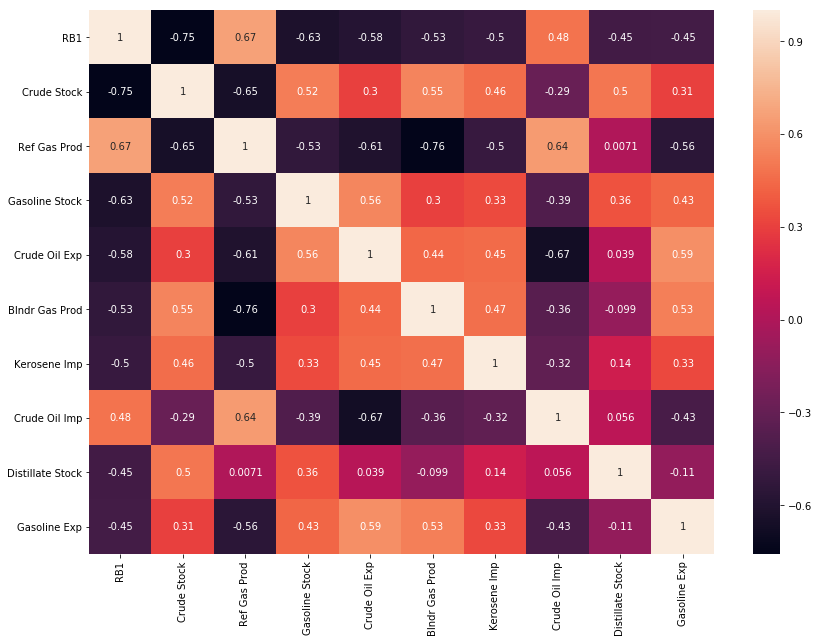

In [53]:
high_corr = ['RB1','Crude Stock','Ref Gas Prod','Gasoline Stock','Crude Oil Exp','Blndr Gas Prod','Kerosene Imp','Crude Oil Imp','Distillate Stock','Gasoline Exp']
plt.figure(figsize=(14,10))
sns.heatmap(df_data[high_corr].corr(), annot=True)

#### Use a pair plot to look at trends to see if a multi-linear model makes sense to predict RB1 based on Fundamental Data


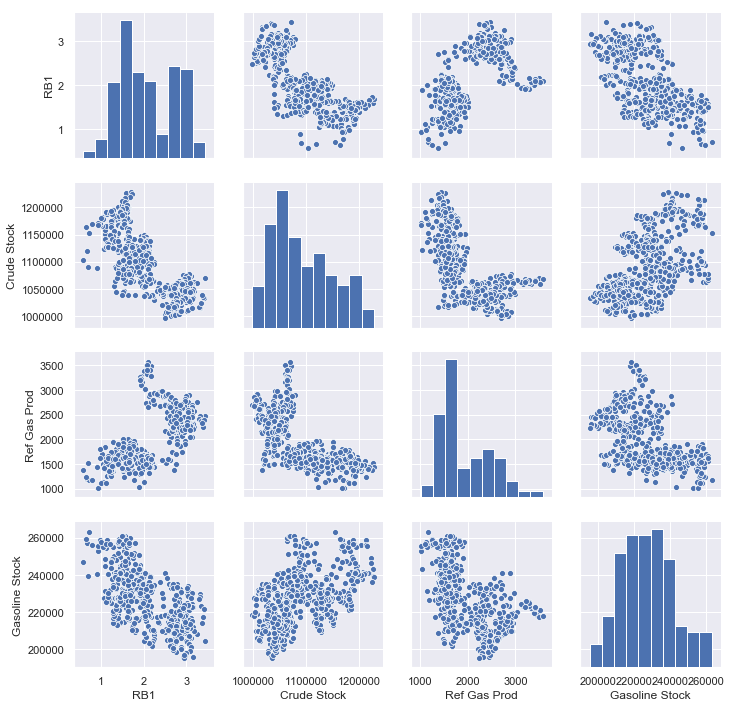

In [54]:
sns.set()
high_corr = ['RB1','Crude Stock','Ref Gas Prod','Gasoline Stock','Crude Oil Exp','Blndr Gas Prod','Kerosene Imp','Crude Oil Imp','Distillate Stock','Gasoline Exp']
high_corr1 = ['RB1','Crude Stock','Ref Gas Prod','Gasoline Stock']
high_corr2 = ['RB1','Crude Oil Exp','Blndr Gas Prod','Kerosene Imp']
high_corr3 = ['RB1','Crude Oil Imp','Distillate Stock','Gasoline Exp' ]
sns.set()
sns.pairplot(df_data[high_corr1])

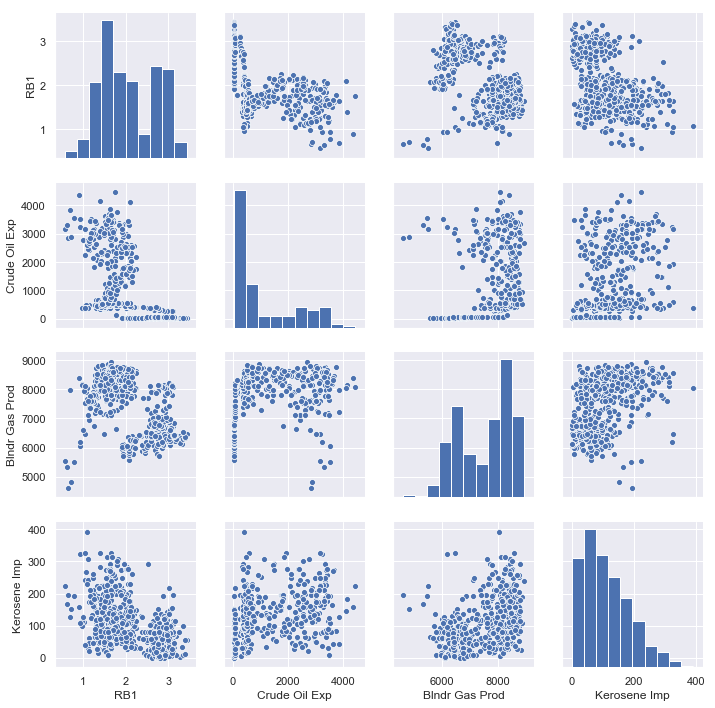

In [55]:
sns.set()
sns.pairplot(df_data[high_corr2])

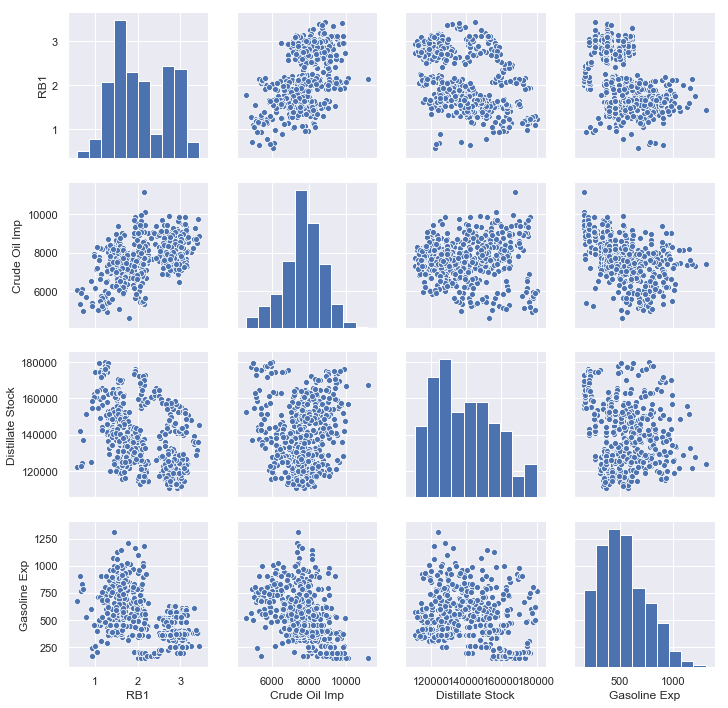

In [56]:
sns.set()
sns.pairplot(df_data[high_corr3])

#### After review, a Multi-Linear Regression model to predict RB contract price will be based on the following fundamental features:
- Crude Stock
- Gasoline Stock
- Crude Oil Export
- Crude Oil Import
- Distillate Stock

#### Note: Other models may be used to predict RB pricing, interesting features, like Production, showed clustering of data which could be further investigated in a follow-up exercise

#### VISUALS Comparing RB1 to Fundamental Data used in Model.

In [57]:
fig = go.Figure()
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(go.Scatter(x=df_data.index, y=df_data['Crude Stock'], name='Crude Stock'),secondary_y=False)
fig.add_trace(go.Scatter(x=df_data.index, y=df_data['RB1'], name='RB1 Price'),secondary_y=True)
fig.layout.update(title='<b>Crude Stock Volume vs. RB1 Price</b>',hovermode='x', xaxis={'title':'Date'},yaxis={'title':'Volume'}, xaxis_rangeslider_visible=True)
fig.update_yaxes(title_text="<b>Crude Volume</b>", secondary_y=False)
fig.update_yaxes(title_text="<b>RB1 Price</b>", secondary_y=True)
pyo.iplot(fig,filename='scatter.html')

In [58]:
fig = go.Figure()
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(go.Scatter(x=df_data.index, y=df_data['Gasoline Stock'], name='Gasoline Stock'),secondary_y=False)
fig.add_trace(go.Scatter(x=df_data.index, y=df_data['RB1'], name='RB1 Price'),secondary_y=True)
fig.layout.update(title='<b>Gasoline Stock Volume vs. RB1 Price</b>',hovermode='x', xaxis={'title':'Date'},yaxis={'title':'Volume'}, xaxis_rangeslider_visible=True)
fig.update_yaxes(title_text="<b>Gasoline Volume</b>", secondary_y=False)
fig.update_yaxes(title_text="<b>RB1 Price</b>", secondary_y=True)
pyo.iplot(fig,filename='scatter.html')

In [59]:
fig = go.Figure()
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(go.Scatter(x=df_data.index, y=df_data['Crude Oil Exp'], name='Crude Oil Export'),secondary_y=False)
fig.add_trace(go.Scatter(x=df_data.index, y=df_data['RB1'], name='RB1 Price'),secondary_y=True)
fig.layout.update(title='<b>Crude Oil Export vs. RB1 Price</b>',hovermode='x', xaxis={'title':'Date'},yaxis={'title':'Volume'}, xaxis_rangeslider_visible=True)
fig.update_yaxes(title_text="<b>Crude Export Volume</b>", secondary_y=False)
fig.update_yaxes(title_text="<b>RB1 Price</b>", secondary_y=True)
pyo.iplot(fig,filename='scatter.html')

In [60]:
fig = go.Figure()
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(go.Scatter(x=df_data.index, y=df_data['Crude Oil Imp'], name='Crude Oil Imp'),secondary_y=False)
fig.add_trace(go.Scatter(x=df_data.index, y=df_data['RB1'], name='RB1 Price'),secondary_y=True)
fig.layout.update(title='<b>Crude Oil Imp vs. RB1 Price</b>',hovermode='x', xaxis={'title':'Date'},yaxis={'title':'Volume'}, xaxis_rangeslider_visible=True)
fig.update_yaxes(title_text="<b>Crude Imp Volume</b>", secondary_y=False)
fig.update_yaxes(title_text="<b>RB1 Price</b>", secondary_y=True)
pyo.iplot(fig,filename='scatter.html')

In [61]:
fig = go.Figure()
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(go.Scatter(x=df_data.index, y=df_data['Distillate Stock'], name='Distillate Stock'),secondary_y=False)
fig.add_trace(go.Scatter(x=df_data.index, y=df_data['RB1'], name='RB1 Price'),secondary_y=True)
fig.layout.update(title='<b>Distillate Stock Volume vs. RB1 Price</b>',hovermode='x', xaxis={'title':'Date'},yaxis={'title':'Volume'}, xaxis_rangeslider_visible=True)
fig.update_yaxes(title_text="<b>Distillate Stock Volume</b>", secondary_y=False)
fig.update_yaxes(title_text="<b>RB1 Price</b>", secondary_y=True)
pyo.iplot(fig,filename='scatter.html')

#### Import the Machine Learning Librairies from SciKit Learn

In [62]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,mean_squared_error

#### Build RB1 Model

In [63]:
X = df_data[['Crude Oil Imp', 'Crude Oil Exp', 'Crude Stock', 'Gasoline Stock','Distillate Stock']]
y = df_data['RB1']

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [65]:
lr_model = LinearRegression()

In [66]:
lr_model.fit(X_train,y_train)

LinearRegression()

In [67]:
test_predictions = lr_model.predict(X_test)

#### Check Model Error:

In [68]:
# Check out Model Error
rb1_mean = df_data['RB1'].mean() # Mean of RB1
MAE = mean_absolute_error(y_test,test_predictions) # Mean Absolute Error
MSE = mean_squared_error(y_test,test_predictions) # Mean Squared Error
RMSE = np.sqrt(MSE) # Root Mean Squared Error
print(df_data['RB1'].mean(), MAE, MSE, RMSE)

2.0725392405063308 0.26933434037959897 0.11945228023087173 0.34561869195816325


#### R-Squared value for Model:

In [69]:
r_squared = lr_model.score(X,y)
r_squared

0.7335631597416923

#### Multi-Linear Regression Coefficients and Intercept

In [70]:
lr_model.coef_, lr_model.intercept_

(array([ 6.72754112e-05, -1.65477413e-04, -5.33637451e-06, -4.68942189e-06,
        -6.10208296e-06]), 9.489403340595208)

#### Build RB2 Model with the same workflow

In [71]:
X = df_data[['Crude Oil Imp', 'Crude Oil Exp', 'Crude Stock', 'Gasoline Stock','Distillate Stock']]
y = df_data['RB2']

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [73]:
lr_model2 = LinearRegression()

In [74]:
lr_model2.fit(X_train,y_train)

LinearRegression()

In [75]:
test_predictions = lr_model2.predict(X_test)

In [76]:
# Check out Model Error
MAE = mean_absolute_error(y_test,test_predictions)
MSE = mean_squared_error(y_test,test_predictions)
RMSE = np.sqrt(MSE)
print(df_data['RB2'].mean(),MAE,MSE,RMSE)

2.0637305605786636 0.26748618385780437 0.11735626490598901 0.3425730066803119


In [77]:
r_squared2 = lr_model2.score(X,y)
r_squared2

0.7233534833989801

In [78]:
lr_model2.coef_, lr_model2.intercept_

(array([ 6.08822664e-05, -1.88353761e-04, -5.52133360e-06, -6.92500692e-07,
        -6.36802149e-06]), 8.884320906336406)

## LOOK AT MONTHLY RB1v2-6 TRENDS
This is an attempt to investigate any monthly trends over 10 years of RB1 contracts diverging from RB2-RB6.  For example: In the month of June, does the difference of RB1-RB2 start small then increase. 

Note: I did not find any correlation, however decided to still include in the notebook for due diligence and to demonstrate data wrangling.  You are welcome to skip ahead!

In [79]:
df_contract = prices[['1v2','1v3','1v4','1v5','1v6']]

In [80]:
df_contract

1v2     1v3     1v4     1v5     1v6
Date                                              
2010-01-04 -0.0125 -0.1250 -0.1621 -0.1339 -0.1355
2010-01-06 -0.0035 -0.1096 -0.1272 -0.1234 -0.1513
2010-01-07 -0.0133 -0.1106 -0.1240 -0.1308 -0.1275
2010-01-08 -0.0103 -0.1137 -0.1200 -0.1267 -0.1405
2010-01-11 -0.0119 -0.1294 -0.1122 -0.1294 -0.1312
...            ...     ...     ...     ...     ...
2021-06-07  0.0064  0.0224  0.1478  0.1834  0.2234
2021-06-08  0.0045  0.0233  0.1421  0.1880  0.2143
2021-06-09  0.0056  0.0204  0.1383  0.1723  0.2007
2021-06-10  0.0020  0.0224  0.1372  0.1609  0.2099
2021-06-11  0.0001  0.0184  0.1371  0.1666  0.2034

[2876 rows x 5 columns]

In [81]:
df_contract['Day'] = df_contract.index.day
df_contract['Month'] = df_contract.index.month
df_contract['Year'] = df_contract.index.year


C:\Users\cmosher\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\cmosher\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\cmosher\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = val

In [82]:
df_contract.head()

1v2     1v3     1v4     1v5     1v6  Day  Month  Year
Date                                                                
2010-01-04 -0.0125 -0.1250 -0.1621 -0.1339 -0.1355    4      1  2010
2010-01-06 -0.0035 -0.1096 -0.1272 -0.1234 -0.1513    6      1  2010
2010-01-07 -0.0133 -0.1106 -0.1240 -0.1308 -0.1275    7      1  2010
2010-01-08 -0.0103 -0.1137 -0.1200 -0.1267 -0.1405    8      1  2010
2010-01-11 -0.0119 -0.1294 -0.1122 -0.1294 -0.1312   11      1  2010

#### Using pivot tables, arrange the data so that we see the daily prices over 10 years for the month of June

In [83]:
contract1v2 = df_contract[df_contract['Month']==6].pivot(index='Day',columns='Year',values='1v2')
contract1v3 = df_contract[df_contract['Month']==6].pivot(index='Day',columns='Year',values='1v3')
contract1v4 = df_contract[df_contract['Month']==6].pivot(index='Day',columns='Year',values='1v4')
contract1v5 = df_contract[df_contract['Month']==6].pivot(index='Day',columns='Year',values='1v5')
contract1v6 = df_contract[df_contract['Month']==6].pivot(index='Day',columns='Year',values='1v6')



#### A look at the Historic daily prices in the Month of June for RB1RB2

In [84]:
contract1v2

Year    2010    2011    2012    2013    2014    2015    2016    2017    2018  \
Day                                                                            
1    -0.0097  0.0308  0.0680     NaN     NaN  0.0381  0.0004  0.0166  0.0072   
2    -0.0253  0.0207     NaN     NaN  0.0365  0.0370  0.0001  0.0097     NaN   
3    -0.0050  0.0245     NaN  0.0221  0.0272  0.0310  0.0024     NaN     NaN   
4     0.0084     NaN  0.0648  0.0209  0.0309  0.0359     NaN     NaN  0.0090   
5        NaN     NaN  0.0672  0.0165  0.0320  0.0305     NaN  0.0116  0.0114   
6        NaN  0.0338  0.0640  0.0203  0.0264     NaN  0.0002  0.0069  0.0078   
7     0.0214  0.0324  0.0476  0.0192     NaN     NaN -0.0075  0.0028  0.0066   
8     0.0016  0.0184  0.0647     NaN     NaN  0.0301 -0.0063  0.0053  0.0116   
9     0.0047  0.0100     NaN     NaN  0.0325  0.0301 -0.0070  0.0107     NaN   
10    0.0065  0.0239     NaN  0.0098  0.0322  0.0394 -0.0114     NaN     NaN   
11   -0.0020     NaN  0.0505  0.0114  0.0301  0.0524     NaN     NaN  0.0052   
12       NaN     NaN  0.0686  0.0085  0.0342  0.0440     NaN  0.0082  0.0051   
13       NaN  0.0206  0.0710  0.0095  0.0392     NaN -0.0098  0.0072  0.0117   
14   -0.0018  0.0238  0.0733  0.0130     NaN     NaN -0.0121  0.0045  0.0153   
15    0.0018  0.0458  0.0832     NaN     NaN  0.0473 -0.0134  0.0005  0.0118   
16    0.0067  0.0534     NaN     NaN  0.0337  0.0465 -0.0146  0.0032     NaN   
17    0.0105  0.0502     NaN  0.0147  0.0308  0.0482 -0.0134     NaN     NaN   
18    0.0100     NaN  0.0713  0.0080  0.0331  0.0407     NaN     NaN  0.0136   
19       NaN     NaN  0.0715  0.0039  0.0318  0.0447     NaN  0.0063  0.0104   
20       NaN  0.0617  0.0732  0.0095  0.0339     NaN -0.0091  0.0104  0.0106   
21   -0.0073  0.0596  0.0887  0.0155     NaN     NaN -0.0121  0.0082  0.0120   
22    0.0051  0.0461  0.0912     NaN     NaN  0.0393 -0.0100  0.0079  0.0157   
23    0.0099  0.0466     NaN     NaN  0.0325  0.0380 -0.0079  0.0109     NaN   
24    0.0077  0.0716     NaN  0.0055  0.0285  0.0337 -0.0075     NaN     NaN   
25    0.0025     NaN  0.1140  0.0130  0.0254  0.0248     NaN     NaN  0.0192   
26       NaN     NaN  0.1487  0.0107  0.0227  0.0295     NaN  0.0124  0.0156   
27       NaN  0.0641  0.1261  0.0158  0.0268     NaN -0.0056  0.0136  0.0161   
28    0.0079  0.0671  0.1137  0.0130     NaN     NaN -0.0087  0.0088  0.0268   
29    0.0045  0.0663  0.1319     NaN     NaN  0.0226 -0.0103  0.0097  0.0281   
30    0.0026  0.0664     NaN     NaN  0.0205  0.0296 -0.0154  0.0095     NaN   

Year    2019    2020    2021  
Day                           
1        NaN -0.0201  0.0066  
2        NaN -0.0117  0.0033  
3     0.0340 -0.0109  0.0086  
4     0.0354 -0.0137  0.0066  
5     0.0314 -0.0138     NaN  
6     0.0342     NaN     NaN  
7     0.0294     NaN  0.0064  
8        NaN -0.0124  0.0045  
9        NaN -0.0082  0.0056  
10    0.0279 -0.0070  0.0020  
11    0.0276 -0.0149  0.0001  
12    0.0354 -0.0168     NaN  
13    0.0255     NaN     NaN  
14    0.0258     NaN     NaN  
15       NaN -0.0213     NaN  
16       NaN -0.0074     NaN  
17    0.0250 -0.0097     NaN  
18    0.0198 -0.0076     NaN  
19    0.0219 -0.0030     NaN  
20    0.0254     NaN     NaN  
21    0.0238     NaN     NaN  
22       NaN -0.0035     NaN  
23       NaN  0.0017     NaN  
24    0.0449  0.0006     NaN  
25    0.0364 -0.0061     NaN  
26    0.0343 -0.0008     NaN  
27    0.0392     NaN     NaN  
28    0.0339     NaN     NaN  
29       NaN -0.0067     NaN  
30       NaN -0.0011     NaN

#### Used a Linear Interpolation over weekends to fill in the NaN values 

In [85]:
contract1v2=contract1v2.interpolate()
contract1v3=contract1v3.interpolate()
contract1v4=contract1v4.interpolate()
contract1v5=contract1v5.interpolate()
contract1v6=contract1v6.interpolate()


In [86]:
contract1v6

Year      2010      2011      2012      2013      2014      2015      2016  \
Day                                                                          
1     0.066900  0.230100  0.298100       NaN       NaN  0.312800  0.210300   
2     0.068000  0.210500  0.305367       NaN  0.324500  0.305900  0.206800   
3     0.086400  0.200200  0.312633  0.219600  0.316100  0.304500  0.210900   
4     0.105600  0.215467  0.319900  0.232800  0.315100  0.314700  0.205467   
5     0.111700  0.230733  0.302400  0.239300  0.317000  0.293600  0.200033   
6     0.117800  0.246000  0.325200  0.231600  0.315800  0.299500  0.194600   
7     0.123900  0.209000  0.296400  0.235100  0.314333  0.305400  0.175800   
8     0.078700  0.206900  0.308800  0.231333  0.312867  0.311300  0.163400   
9     0.100500  0.147400  0.290300  0.227567  0.311400  0.300500  0.166000   
10    0.087500  0.179700  0.271800  0.223800  0.323400  0.331400  0.167500   
11    0.102500  0.182200  0.253300  0.221100  0.317900  0.344900  0.162267   
12    0.103267  0.184700  0.314100  0.219500  0.326300  0.336500  0.157033   
13    0.104033  0.187200  0.324900  0.209400  0.337600  0.347067  0.151800   
14    0.104800  0.184400  0.330200  0.223700  0.330233  0.357633  0.143800   
15    0.101700  0.219700  0.335400  0.222967  0.322867  0.368200  0.126800   
16    0.119900  0.218800  0.340033  0.222233  0.315500  0.339800  0.129900   
17    0.133000  0.226700  0.344667  0.221500  0.326700  0.381100  0.122200   
18    0.138700  0.228833  0.349300  0.210200  0.318700  0.340900  0.124000   
19    0.126833  0.230967  0.338700  0.205300  0.315900  0.346700  0.125800   
20    0.114967  0.233100  0.331600  0.210900  0.336000  0.341400  0.127600   
21    0.103100  0.227800  0.353500  0.215000  0.333233  0.336100  0.151400   
22    0.119500  0.204300  0.371200  0.214733  0.330467  0.330800  0.160500   
23    0.128000  0.225100  0.374567  0.214467  0.327700  0.313900  0.166700   
24    0.122100  0.227700  0.377933  0.214200  0.325800  0.314200  0.164200   
25    0.122700  0.220367  0.381300  0.207000  0.316700  0.303800  0.162267   
26    0.129267  0.213033  0.439300  0.201200  0.315600  0.307800  0.160333   
27    0.135833  0.205700  0.408700  0.193100  0.314100  0.313833  0.158400   
28    0.142400  0.228400  0.387000  0.177000  0.316733  0.319867  0.141700   
29    0.136500  0.240700  0.413100  0.177000  0.319367  0.325900  0.136700   
30    0.123800  0.266100  0.413100  0.177000  0.322000  0.327500  0.120500   

Year      2017      2018      2019      2020      2021  
Day                                                     
1     0.175700  0.199100       NaN  0.066300  0.218500  
2     0.191500  0.199067       NaN  0.068900  0.213300  
3     0.189367  0.199033  0.272500  0.086400  0.206400  
4     0.187233  0.199000  0.255300  0.085300  0.222600  
5     0.185100  0.198500  0.237800  0.086800  0.222867  
6     0.162200  0.194000  0.258300  0.087167  0.223133  
7     0.149600  0.182500  0.256000  0.087533  0.223400  
8     0.155300  0.181700  0.251500  0.087900  0.214300  
9     0.156900  0.186600  0.247000  0.107500  0.200700  
10    0.154300  0.191500  0.242500  0.108500  0.209900  
11    0.151700  0.196400  0.249300  0.101300  0.203400  
12    0.149100  0.185700  0.271600  0.092200  0.203400  
13    0.140500  0.183300  0.235400  0.094367  0.203400  
14    0.143500  0.190500  0.248700  0.096533  0.203400  
15    0.121800  0.188100  0.253500  0.098700  0.203400  
16    0.128600  0.187967  0.258300  0.096700  0.203400  
17    0.129233  0.187833  0.263100  0.108000  0.203400  
18    0.129867  0.187700  0.246100  0.125100  0.203400  
19    0.130500  0.179000  0.240800  0.149500  0.203400  
20    0.128700  0.164100  0.235300  0.150467  0.203400  
21    0.125600  0.175700  0.232200  0.151433  0.203400  
22    0.138500  0.187700  0.248533  0.152400  0.203400  
23    0.151300  0.188733  0.264867  0.140300  0.203400  
24    0.148633  0.189767  0.281200  0.143300  0.203400  
25    0.145967  0.190

#### Plot the contract prices for RB1-RB2 for the month of June 

In [87]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=contract1v2.index, y=contract1v2[2010], name='2010'))
fig.add_trace(go.Scatter(x=contract1v2.index, y=contract1v2[2011], name='2011'))
fig.add_trace(go.Scatter(x=contract1v2.index, y=contract1v2[2012], name='2012'))
fig.add_trace(go.Scatter(x=contract1v2.index, y=contract1v2[2013], name='2013'))
fig.add_trace(go.Scatter(x=contract1v2.index, y=contract1v2[2014], name='2014'))
fig.add_trace(go.Scatter(x=contract1v2.index, y=contract1v2[2015], name='2015'))
fig.add_trace(go.Scatter(x=contract1v2.index, y=contract1v2[2016], name='2016'))
fig.add_trace(go.Scatter(x=contract1v2.index, y=contract1v2[2017], name='2017'))
fig.add_trace(go.Scatter(x=contract1v2.index, y=contract1v2[2018], name='2018'))
fig.add_trace(go.Scatter(x=contract1v2.index, y=contract1v2[2019], name='2019'))
fig.add_trace(go.Scatter(x=contract1v2.index, y=contract1v2[2020], name='2020'))


fig.layout.update(title='Historical RB Contract Spreads', xaxis={'title':'Day of June'},yaxis={'title':'Price Difference($)'},hovermode='x', xaxis_rangeslider_visible=True)
pyo.iplot(fig)

In [88]:
#### Scaling each years numbers to a common point using a Standard Scalar algorithm

In [89]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

contract1v2_scaled = scaler.fit_transform(contract1v2)

columns_scaled = [2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021]
contract1v2_scaled = pd.DataFrame(data=contract1v2_scaled, columns=columns_scaled)

In [90]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=contract1v2_scaled.index, y=contract1v2_scaled[2010], name='2010'))
fig.add_trace(go.Scatter(x=contract1v2_scaled.index, y=contract1v2_scaled[2011], name='2011'))
fig.add_trace(go.Scatter(x=contract1v2_scaled.index, y=contract1v2_scaled[2012], name='2012'))
fig.add_trace(go.Scatter(x=contract1v2_scaled.index, y=contract1v2_scaled[2013], name='2013'))
fig.add_trace(go.Scatter(x=contract1v2_scaled.index, y=contract1v2_scaled[2014], name='2014'))
fig.add_trace(go.Scatter(x=contract1v2_scaled.index, y=contract1v2_scaled[2015], name='2015'))
fig.add_trace(go.Scatter(x=contract1v2_scaled.index, y=contract1v2_scaled[2016], name='2016'))
fig.add_trace(go.Scatter(x=contract1v2_scaled.index, y=contract1v2_scaled[2017], name='2017'))
fig.add_trace(go.Scatter(x=contract1v2_scaled.index, y=contract1v2_scaled[2018], name='2018'))
fig.add_trace(go.Scatter(x=contract1v2_scaled.index, y=contract1v2_scaled[2019], name='2019'))
fig.add_trace(go.Scatter(x=contract1v2_scaled.index, y=contract1v2_scaled[2020], name='2020'))


fig.layout.update(title='Historical RB Contract Spreads', xaxis={'title':'Day of June'},yaxis={'title':'Price Difference($)'},hovermode='x', xaxis_rangeslider_visible=True)
pyo.iplot(fig)

#### Little correlation to suggest that there is a monthly pattern of RB1 vs RB2 divergence

## Investigation Contract Settlement Dates

Contract Settlment Days are a good reflection of final information being priced into the market from a speculatory standpoint, it is considered the most robust reflection of known supply/demand expectations as well as physical real-world implications possible, thus a great candidate to compare against fundamental data to create a fair value model going forward.  The price paths leading up to expiry try to price all of this is, but it reflects more uncertainty as a function of time and potential shifts in Supply/Demand (refinery goes down, Iran sanctions,etc.) that could yet play out before a contract expires thus making price volatile. 

Next Step, we will filter data based on Contract Settlement Dates vs. The positive correlations we saw when looking at fundamentals of RB1

#### Account for NYSE Holidays

In [91]:
nyse = mcal.get_calendar("NYSE")
us_holidays = nyse.holidays()

us_holiday_list = list(map(lambda x: pd.to_datetime(str(x)).strftime('%Y-%m-%d'),us_holidays.holidays))

start = '2010-01-01'
end = date.today().strftime('%Y-%m-%d')



#### Get expiry schedule

In [92]:
rb_expiry_dates = pd.bdate_range(start,end,freq='CBM',holidays=us_holiday_list)

In [93]:
rb_expiry_dates

DatetimeIndex(['2010-01-29', '2010-02-26', '2010-03-31', '2010-04-30',
               '2010-05-28', '2010-06-30', '2010-07-30', '2010-08-31',
               '2010-09-30', '2010-10-29',
               ...
               '2020-08-31', '2020-09-30', '2020-10-30', '2020-11-30',
               '2020-12-31', '2021-01-29', '2021-02-26', '2021-03-31',
               '2021-04-30', '2021-05-28'],
              dtype='datetime64[ns]', length=137, freq='CBM')

In [94]:
df_data.columns

Index(['Ref Gas Prod', 'Ref Dist Prod', 'Ref Kero Prod', 'Blndr Gas Prod',
       'Blndr Dist Prod', 'Bldr Kero Prod', 'Crude Oil Imp', 'Gasoline Imp',
       'Kerosene Imp', 'Distillate Imp', 'Crude Oil Exp', 'Gasoline Exp',
       'Kerosene Exp', 'Distillate Exp', 'Crude Stock', 'Gasoline Stock',
       'Kerosene Stock', 'Distillate Stock', 'Consumed Gas', 'Consumed Kero',
       'Consumed Distillate', 'Date', 'RB1', 'RB2', 'RB3', 'RB4', 'RB5', 'RB6',
       '1v2', '1v3', '1v4', '1v5', '1v6'],
      dtype='object')

#### Locate Prices for Expiry Dates

In [95]:
# Get prices for expiry dates 
df_expiry=[]
df_fund = df_data[['Ref Gas Prod', 'Ref Dist Prod', 'Ref Kero Prod', 'Blndr Gas Prod',
       'Blndr Dist Prod', 'Bldr Kero Prod', 'Crude Oil Imp', 'Gasoline Imp',
       'Kerosene Imp', 'Distillate Imp', 'Crude Oil Exp', 'Gasoline Exp',
       'Kerosene Exp', 'Distillate Exp', 'Crude Stock', 'Gasoline Stock',
       'Kerosene Stock', 'Distillate Stock', 'Consumed Gas', 'Consumed Kero',
       'Consumed Distillate']]
df_expiry = pd.concat([prices,df_fund],axis=1, join='outer')
df_expiry = df_expiry.fillna(method='ffill')


In [96]:
# Filter on Contract Expiry Dates
df_expiry = df_expiry.loc[rb_expiry_dates]
df_expiry['Month'] = df_expiry.index.month
df_expiry.dropna(inplace=True)


In [97]:
df_expiry.dropna(inplace=True)

#### Final DataFrame with only Expiry Dates

In [98]:
df_expiry.head(10)

RB1     RB2     RB3     RB4     RB5     RB6     1v2     1v3  \
2010-06-30  2.0614  2.0588  2.0485  1.9370  1.9280  1.9376  0.0026  0.0129   
2010-07-30  2.0847  2.1004  1.9980  1.9824  1.9900  2.0027 -0.0157  0.0867   
2010-08-31  1.9280  1.9000  1.9035  1.9120  1.9364  1.9595  0.0280  0.0245   
2010-09-30  1.9955  1.9840  1.9900  2.0130  2.0476  2.0546  0.0115  0.0055   
2010-10-29  2.1040  2.0740  2.0832  2.1010  2.1227  2.2491  0.0300  0.0208   
2010-11-30  2.2811  2.2251  2.2188  2.2307  2.3330  2.3261  0.0560  0.0623   
2010-12-31  2.3966  2.3953  2.4835  2.4885  2.4909  2.4664  0.0013 -0.0869   
2011-01-31  2.4795  2.4920  2.6249  2.6388  2.6262  2.6008 -0.0125 -0.1454   
2011-02-28  2.7662  2.9145  2.9300  2.9467  2.9386  2.9350 -0.1483 -0.1638   
2011-03-31  3.0650  3.0600  3.0425  3.0300  3.0186  2.9878  0.0050  0.0225   

               1v4     1v5     1v6  Ref Gas Prod  Ref Dist Prod  \
2010-06-30  0.1244  0.1334  0.1238        3569.0         4376.0   
2010-07-30  0.1023  0.0947  0.0820        3417.0         4349.0   
2010-08-31  0.0160 -0.0084 -0.0315        3199.0         4300.0   
2010-09-30 -0.0175 -0.0521 -0.0591        3197.0         4291.0   
2010-10-29  0.0030 -0.0187 -0.1451        2663.0         4222.0   
2010-11-30  0.0504 -0.0519 -0.0450        2802.0         4288.0   
2010-12-31 -0.0919 -0.0943 -0.0698        2983.0         4622.0   
2011-01-31 -0.1593 -0.1467 -0.1213        2677.0         4236.0   
2011-02-28 -0.1805 -0.1724 -0.1688        2708.0         4107.0   
2011-03-31  0.0350  0.0464  0.0772        2721.0         4205.0   

            Ref Kero Prod  Blndr Gas Prod  Blndr Dist Prod  Bldr Kero Prod  \
2010-06-30           25.0          5811.0              0.0            -1.0   
2010-07-30           21.0          5975.0              2.0             0.0   
2010-08-31            5.0          6088.0              3.0             0.0   
2010-09-30           39.0          6008.0              0.0             0.0   
2010-10-29           44.0          6266.0             19.0             9.0   
2010-11-30           47.0          5986.0             16.0             1.0   
2010-12-31           25.0          5879.0              3.0             5.0   
2011-01-31           21.0          6098.0            -54.0             7.0   
2011-02-28           32.0          6396.0             -1.0             3.0   
2011-03-31           17.0          6100.0             28.0             1.0   

            Crude Oil Imp  Gasoline Imp  Kerosene Imp  Distillate Imp  \
2010-06-30         9481.0        1031.0          54.0           183.0   
2010-07-30         9629.0        1233.0          65.0           187.0   
2010-08-31         9679.0        1142.0          69.0           196.0   
2010-09-30         9005.0         881.0         120.0           195.0   
2010-10-29         8578.0         871.0          74.0            92.0   
2010-11-30         8446.0         698.0          35.0           112.0   
2010-12-31         8446.0         513.0          81.0           156.0   
2011-01-31         9014.0        1173.0         127.0           318.0   
2011-02-28         8010.0         808.0          51.0           170.0   
2011-03-31         9128.0         884.0         101.0           243.0   

            Crude Oil Exp  Gasoline Exp  Kerosene Exp  Distillate Exp  \
2010-06-30           33.0         155.0          61.0           658.0   
2010-07-30           33.0         155.0          62.0           763.0   
2010-08-31           32.0         198.0          56.0           677.0   
2010-09-30           33.0         211.0          61.0           768.0   
2010-10-29           33.0         200.0          65.0           737.0   
2010-11-30           34.0         167.0          65.0           777.0   
2010-12-31           33.0         168.0          59.0           882.0   
2011-01-31           33.0         199.0          70.0           835.0   
2011-02-28           33.0         223.0          87.0           686.0   
2011-03-31           34.0

#### Investigate Summer and Winter Months

In [99]:
# Next Six Months
summer_df = df_expiry.loc[(df_expiry['Month'] >= 4) & (df_expiry['Month'] <= 9)]
winter_df = df_expiry.loc[(df_expiry['Month'] >= 10) | (df_expiry['Month'] <= 3)]


In [100]:
winter_df

RB1     RB2     RB3     RB4     RB5     RB6     1v2     1v3  \
2010-10-29  2.1040  2.0740  2.0832  2.1010  2.1227  2.2491  0.0300  0.0208   
2010-11-30  2.2811  2.2251  2.2188  2.2307  2.3330  2.3261  0.0560  0.0623   
2010-12-31  2.3966  2.3953  2.4835  2.4885  2.4909  2.4664  0.0013 -0.0869   
2011-01-31  2.4795  2.4920  2.6249  2.6388  2.6262  2.6008 -0.0125 -0.1454   
2011-02-28  2.7662  2.9145  2.9300  2.9467  2.9386  2.9350 -0.1483 -0.1638   
2011-03-31  3.0650  3.0600  3.0425  3.0300  3.0186  2.9878  0.0050  0.0225   
2011-10-31  2.6859  2.6511  2.6262  2.6390  2.6163  2.7712  0.0348  0.0597   
2011-11-30  2.5464  2.5352  2.5575  2.5851  2.7241  2.7635  0.0112 -0.0111   
2011-12-30  2.6808  2.6739  2.6747  2.7843  2.7800  2.7464  0.0069  0.0061   
2012-01-31  2.8876  2.8775  3.0022  2.9829  2.9605  2.9340  0.0101 -0.1146   
2012-02-29  3.0394  3.2251  3.2208  3.1940  3.1572  3.1159 -0.1857 -0.1814   
2012-03-30  3.4050  3.3420  3.2817  3.2331  3.1728  3.1184  0.0630  0.1233   
2012-10-31  2.7815  2.6267  2.6017  2.6118  2.6363  2.7785  0.1548  0.1798   
2012-11-30  2.7774  2.7225  2.7192  2.7304  2.8741  2.8791  0.0549  0.0582   
2012-12-31  2.7943  2.7561  2.7580  2.8895  2.8591  2.8635  0.0382  0.0363   
2013-01-31  3.0349  3.0250  3.1736  3.1346  3.0798  3.0297  0.0099 -0.1387   
2013-02-28  2.8695  3.1124  3.0850  3.0365  2.9785  2.9163 -0.2429 -0.2155   
2013-03-28  3.1155  3.1118  3.0771  3.0381  2.9898  2.9481  0.0037  0.0384   
2013-10-31  2.6409  2.6165  2.6154  2.6330  2.6466  2.8100  0.0244  0.0255   
2013-11-29  2.7047  2.6965  2.7098  2.7353  2.9034  2.9040  0.0082 -0.0051   
2013-12-31  2.7914  2.7839  2.7960  2.9674  2.9665  2.9268  0.0075 -0.0046   
2014-01-31  2.6765  2.6840  2.8550  2.8570  2.8346  2.8000 -0.0075 -0.1785   
2014-02-28  2.7511  2.9590  2.9450  2.9171  2.8798  2.8388 -0.2079 -0.1939   
2014-03-31  2.9305  2.9244  2.9172  2.8794  2.8544  2.8163  0.0061  0.0133   
2014-10-31  2.1955  2.1610  2.1563  2.1669  2.1874  2.3821  0.0345  0.0392   
2014-11-28  2.0122  2.0010  2.0006  2.0086  2.2000  2.2085  0.0112  0.0116   
2014-12-31  1.4495  1.4655  1.4900  1.7085  1.7244  1.7252 -0.0160 -0.0405   
2015-01-30  1.3600  1.3970  1.6089  1.6268  1.6279  1.6188 -0.0370 -0.2489   
2015-02-27  1.7175  1.9171  1.9061  1.9000  1.8806  1.8754 -0.1996 -0.1886   
2015-03-31  1.7951  1.7960  1.7951  1.7770  1.7507  1.7377 -0.0009  0.0000   
2015-10-30  1.3480  1.3400  1.3413  1.3615  1.3924  1.6068  0.0080  0.0067   
2015-11-30  1.3904  1.3379  1.3364  1.3634  1.5785  1.5926  0.0525  0.0540   
2015-12-31  1.2415  1.2532  1.2814  1.4913  1.4940  1.5048 -0.0117 -0.0399   
2016-01-29  1.1195  1.3333  1.3470  1.3450  1.3369  1.2990 -0.2138 -0.2275   
2016-02-29  1.2900  1.3166  1.3155  1.3171  1.3017  1.2812 -0.0266 -0.0255   
2016-03-31  1.4297  1.4600  1.4745  1.4666  1.4396  1.4132 -0.0303 -0.0448   
2016-10-31  1.4642  1.4528  1.4538  1.4637  1.4875  1.6740  0.0114  0.0104   
2016-11-30  1.3776  1.3770  1.3847  1.4058  1.6088  1.6244  0.0006 -0.0071   
2016-12-30  1.6763  1.6776  1.6895  1.8599  1.8687  1.8634 -0.0013 -0.0132   
2017-01-31  1.5041  1.5293  1.7455  1.7694  1.7703  1.7550 -0.0252 -0.2414   
2017-02-28  1.5305  1.7412  1.7628  1.7697  1.7655  1.7439 -0.2107 -0.2323   
2017-03-31  1.6890  1.6837  1.6861  1.6740  1.6507  1.6332  0.0053  0.0029   
2017-10-31  1.7663  1.7150  1.6946  1.6944  1.7070  1.8717  0.0513  0.0717   
2017-11-30  1.7320  1.7371  1.7474  1.7623  1.9277  1.9344 -0.0051 -0.0154   
2017-12-29  1.7900  1.7933  1.8080  1.9839  1.9892  1.9865 -0.0033 -0.0180   
2018-01-31  1.8798  1.8572  2.0211  2.0288  2.0192  2.0057  0.0226 -0.1413   
2018-02-28  1.7965  1.9780  1.9921  1.9869  1.9699  1.9478 -0.1815 -0.1956   
2018-03-29  2.0154  2.0250  2.0260  2.0189  1.9990  1.9770 -0.0096 -0.0106   
2018-10-31  1.8100  1.8067  1.8074  1.8237  1.8436  2.0524  0.0033  0.0026   
2018-11-30  1.4471  1.4225  1.4217  1.4450  1.6499  1.6593  0.0246  0.0254   
2018-12-31  1.3285  1.2929  1.2997  1

In [101]:
data = go.Scatter(x=summer_df['1v2'],y=summer_df['Gasoline Stock'],mode='markers')
layout = go.Layout(yaxis = dict(title='Crude Stock'),xaxis = dict(title='1v2 Summer Contract Spread'))
fig = go.Figure(data=data,layout=layout)
pyo.iplot(fig)

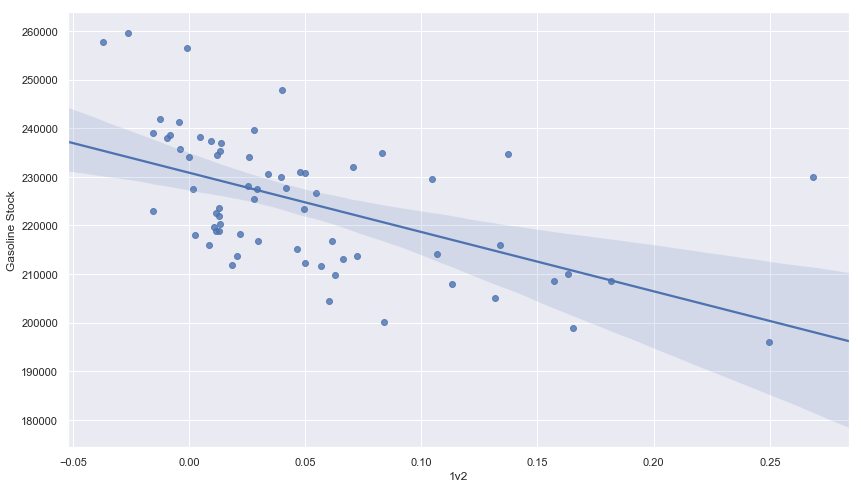

In [102]:
sns.set()
plt.figure(figsize=(14,8))
sns.regplot(x="1v2", y="Gasoline Stock", data=summer_df)

In [103]:
data = go.Scatter(x=winter_df['1v2'],y=winter_df['Gasoline Stock'],mode='markers')
layout = go.Layout(yaxis = dict(title='Crude Stock'),xaxis = dict(title='1v2 Winter Contract Spread'))
fig = go.Figure(data=data,layout=layout)
pyo.iplot(fig)

#### Noted that using the Expiry Dates show similar negatively correlating pattern vs. Fundamental Data as weekly Dataset

## FORECAST FUNDAMENTALS USING FACEBOOK PROPHET

In [104]:
crude_stock = df_data[['Date','Crude Stock']]
gasoline_stock = df_data[['Date','Gasoline Stock']]
crude_oil_exp = df_data[['Date','Crude Oil Exp']]
crude_oil_imp = df_data[['Date','Crude Oil Imp']]
dist_stock = df_data[['Date','Distillate Stock']]

#### facebook prophet requires data in this form

In [105]:
crude_stock = crude_stock.rename(columns={'Date':'ds','Crude Stock':'y'})
gasoline_stock = gasoline_stock.rename(columns={'Date':'ds','Gasoline Stock':'y'})
crude_oil_exp = crude_oil_exp.rename(columns={'Date':'ds','Crude Oil Exp':'y'})
crude_oil_imp = crude_oil_imp.rename(columns={'Date':'ds','Crude Oil Imp':'y'})
dist_stock = dist_stock.rename(columns={'Date':'ds','Distillate Stock':'y'})

#### Build and Fit the Forecasting Model

In [106]:

m_crude_stock = Prophet(interval_width=0.85)
m_gasoline_stock = Prophet(interval_width=0.85)
m_crude_oil_exp = Prophet(interval_width=0.85)
m_crude_oil_imp = Prophet(interval_width=0.85)
m_dist_stock = Prophet(interval_width=0.85)


In [107]:
m_crude_stock.fit(crude_stock)
m_gasoline_stock.fit(gasoline_stock)
m_crude_oil_exp.fit(crude_oil_exp)
m_crude_oil_imp.fit(crude_oil_imp)
m_dist_stock.fit(dist_stock)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

#### Create Future Weekly Data based on the Model

In [108]:
fut_crude_stock = m_crude_stock.make_future_dataframe(periods=30, freq = 'W')
fut_gasoline_stock = m_gasoline_stock.make_future_dataframe(periods=30, freq = 'W')
fut_crude_oil_exp = m_crude_oil_exp.make_future_dataframe(periods=30, freq = 'W')
fut_crude_oil_imp = m_crude_oil_imp.make_future_dataframe(periods=30, freq = 'W')
fut_dist_stock = m_dist_stock.make_future_dataframe(periods=30, freq = 'W')

In [109]:
for_crude_stock = m_crude_stock.predict(fut_crude_stock)
for_gasoline_stock = m_gasoline_stock.predict(fut_gasoline_stock)
for_crude_oil_exp = m_crude_oil_exp.predict(fut_crude_oil_exp)
for_crude_oil_imp = m_crude_oil_imp.predict(fut_crude_oil_imp)
for_dist_stock = m_dist_stock.predict(fut_dist_stock)


## Crude Stock Prediction

In [110]:
for_crude_stock.tail()

ds         trend    yhat_lower    yhat_upper   trend_lower  \
578 2021-11-21  1.150710e+06  1.121459e+06  1.173601e+06  1.139742e+06   
579 2021-11-28  1.151133e+06  1.119318e+06  1.171095e+06  1.139469e+06   
580 2021-12-05  1.151556e+06  1.118830e+06  1.168567e+06  1.138924e+06   
581 2021-12-12  1.151979e+06  1.115528e+06  1.167221e+06  1.138703e+06   
582 2021-12-19  1.152401e+06  1.111715e+06  1.164256e+06  1.138312e+06   

      trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
578  1.161814e+06    -4874.091894          -4874.091894          -4874.091894   
579  1.163090e+06    -6699.241253          -6699.241253          -6699.241253   
580  1.164287e+06    -8544.764442          -8544.764442          -8544.764442   
581  1.165609e+06   -11029.241214         -11029.241214         -11029.241214   
582  1.166999e+06   -14746.693370         -14746.693370         -14746.693370   

           yearly  yearly_lower  yearly_upper  multiplicative_terms  \
578  -4874.091894  -4874.091894  -4874.091894                   0.0   
579  -6699.241253  -6699.241253  -6699.241253                   0.0   
580  -8544.764442  -8544.764442  -8544.764442                   0.0   
581 -11029.241214 -11029.241214 -11029.241214                   0.0   
582 -14746.693370 -14746.693370 -14746.693370                   0.0   

     multiplicative_terms_lower  multiplicative_terms_upper          yhat  
578                         0.0                         0.0  1.145836e+06  
579                         0.0                         0.0  1.144434e+06  
580                         0.0                         0.0  1.143011e+06  
581                         0.0                         0.0  1.140949e+06  
582                         0.0                         0.0  1.137655e+06

#### Plot 1 shows actual and Modeled Data
#### Plot 2 shows the background trend of the model
#### Plot 3 shows you the yearly trend it observes in the data
#### Trends suggests that Crude Stock are higher in May/June and decrease in January

C:\Users\cmosher\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1377: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

C:\Users\cmosher\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_base.py:239: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

C:\Users\cmosher\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1377: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

C:\Users\cmosher\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_base.py:239: FutureWarning:

Support for multi-dimensio

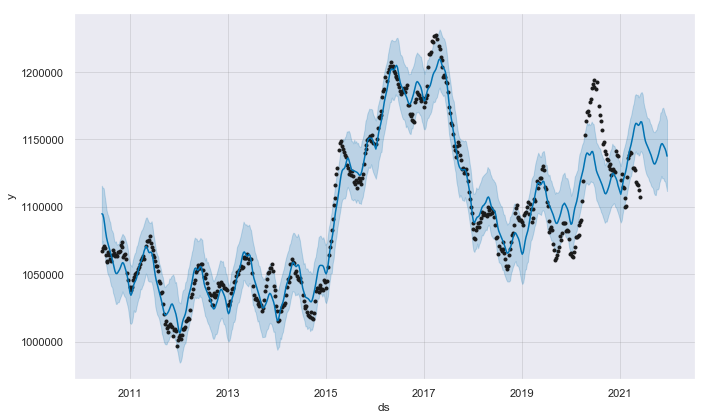

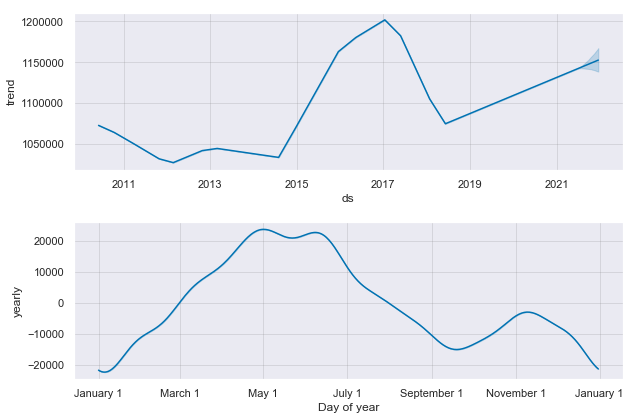

In [111]:
plot_fut_crude_stock1 = m_crude_stock.plot(for_crude_stock)
plot_fut_crude_stock2 = m_crude_stock.plot_components(for_crude_stock)

## Gasoline Stock Prediction

#### Plot 1 shows actual and Modeled Data
#### Plot 2 shows the background trend of the model
#### Plot 3 shows you the yearly trend it observes in the data
#### Trends suggests that there is seasonality to Gasonline inventories

C:\Users\cmosher\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1377: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

C:\Users\cmosher\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_base.py:239: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.



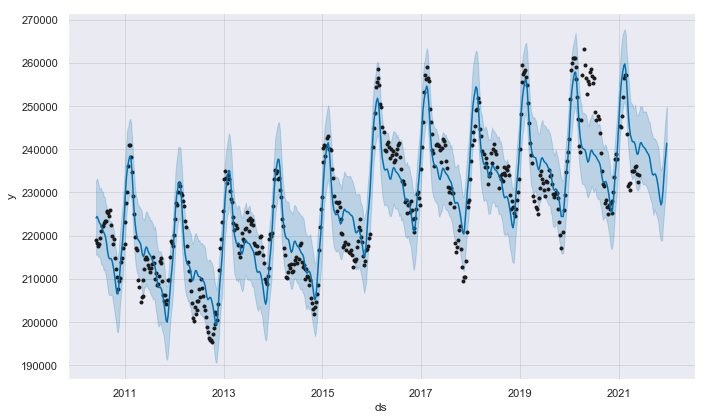

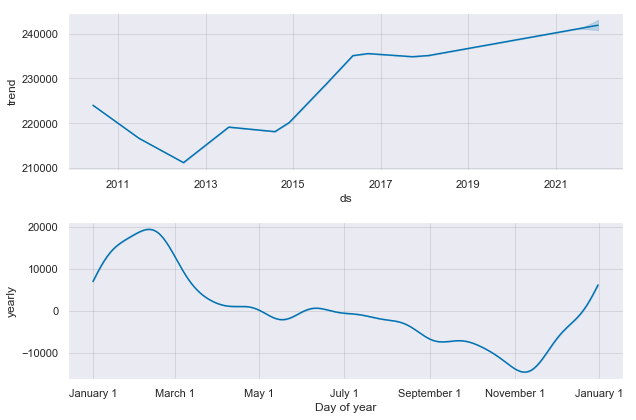

In [112]:
plot_fut_gasoline_stock = m_gasoline_stock.plot(for_gasoline_stock)
plot_fut_gasoline_stock = m_gasoline_stock.plot_components(for_gasoline_stock)

## Crude Oil Exp

#### Plot 1 shows actual and Modeled Data
#### Plot 2 shows the background trend of the model
#### Plot 3 shows you the yearly trend it observes in the data
#### No yearly trends apparent, however USA continues to export more crude, which coincides with the Permian Basin Asset discovery

In [113]:
for_crude_oil_exp.tail()

ds        trend   yhat_lower   yhat_upper  trend_lower  \
578 2021-11-21  3328.514539  2861.508101  3759.272005  3292.064635   
579 2021-11-28  3333.233989  2877.015925  3790.929407  3295.098408   
580 2021-12-05  3337.953438  2889.201864  3823.286889  3296.786349   
581 2021-12-12  3342.672888  2922.673313  3791.533586  3298.438923   
582 2021-12-19  3347.392338  2956.098484  3828.895398  3301.447953   

     trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
578  3367.179950      -14.962531            -14.962531            -14.962531   
579  3375.103724       12.025730             12.025730             12.025730   
580  3382.531858       11.765577             11.765577             11.765577   
581  3390.917844       11.121197             11.121197             11.121197   
582  3398.527882       34.005826             34.005826             34.005826   

        yearly  yearly_lower  yearly_upper  multiplicative_terms  \
578 -14.962531    -14.962531    -14.962531                   0.0   
579  12.025730     12.025730     12.025730                   0.0   
580  11.765577     11.765577     11.765577                   0.0   
581  11.121197     11.121197     11.121197                   0.0   
582  34.005826     34.005826     34.005826                   0.0   

     multiplicative_terms_lower  multiplicative_terms_upper         yhat  
578                         0.0                         0.0  3313.552008  
579                         0.0                         0.0  3345.259719  
580                         0.0                         0.0  3349.719016  
581                         0.0                         0.0  3353.794085  
582                         0.0                         0.0  3381.398164

C:\Users\cmosher\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1377: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

C:\Users\cmosher\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_base.py:239: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

C:\Users\cmosher\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1377: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

C:\Users\cmosher\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_base.py:239: FutureWarning:

Support for multi-dimensio

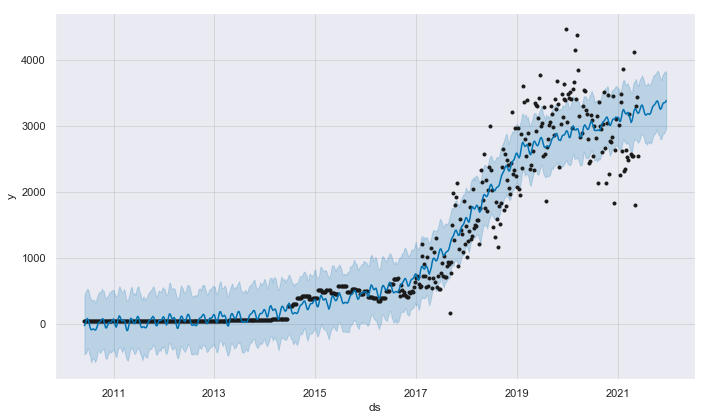

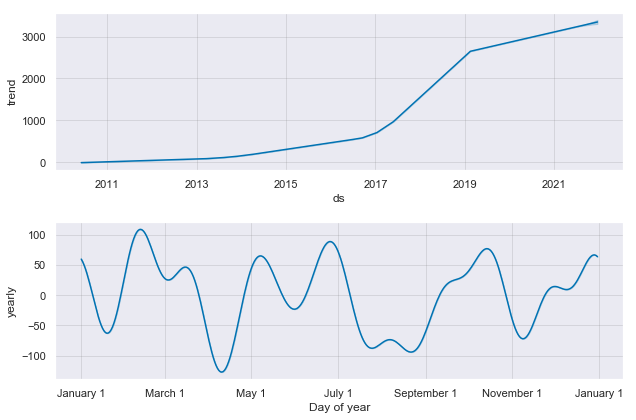

In [114]:
plot_fut_crude_oil_exp = m_crude_oil_exp.plot(for_crude_oil_exp)
plot_fut_crude_oil_exp = m_crude_oil_exp.plot_components(for_crude_oil_exp)

## Crude Oil Import Forecast

#### Plot 1 shows actual and Modeled Data
#### Plot 2 shows the background trend of the model
#### Plot 3 shows you the yearly trend it observes in the data
#### Trends suggests USA Imports less Foreign Oil as it becomes Energy sufficient

In [115]:
for_crude_oil_imp.tail()

ds        trend   yhat_lower   yhat_upper  trend_lower  \
578 2021-11-21  4932.909639  4100.032038  5503.248368  4895.198210   
579 2021-11-28  4917.012184  4097.172560  5526.292397  4877.602288   
580 2021-12-05  4901.114729  4175.675763  5564.289877  4858.633503   
581 2021-12-12  4885.217275  4155.473642  5468.193027  4840.477768   
582 2021-12-19  4869.319820  4108.255609  5537.662143  4822.711752   

     trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
578  4975.782298     -156.951288           -156.951288           -156.951288   
579  4963.447262      -73.309163            -73.309163            -73.309163   
580  4950.219172      -43.995576            -43.995576            -43.995576   
581  4936.974973      -59.129648            -59.129648            -59.129648   
582  4923.691963      -66.500817            -66.500817            -66.500817   

         yearly  yearly_lower  yearly_upper  multiplicative_terms  \
578 -156.951288   -156.951288   -156.951288                   0.0   
579  -73.309163    -73.309163    -73.309163                   0.0   
580  -43.995576    -43.995576    -43.995576                   0.0   
581  -59.129648    -59.129648    -59.129648                   0.0   
582  -66.500817    -66.500817    -66.500817                   0.0   

     multiplicative_terms_lower  multiplicative_terms_upper         yhat  
578                         0.0                         0.0  4775.958351  
579                         0.0                         0.0  4843.703021  
580                         0.0                         0.0  4857.119154  
581                         0.0                         0.0  4826.087627  
582                         0.0                         0.0  4802.819002

C:\Users\cmosher\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1377: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

C:\Users\cmosher\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_base.py:239: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

C:\Users\cmosher\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1377: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

C:\Users\cmosher\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_base.py:239: FutureWarning:

Support for multi-dimensio

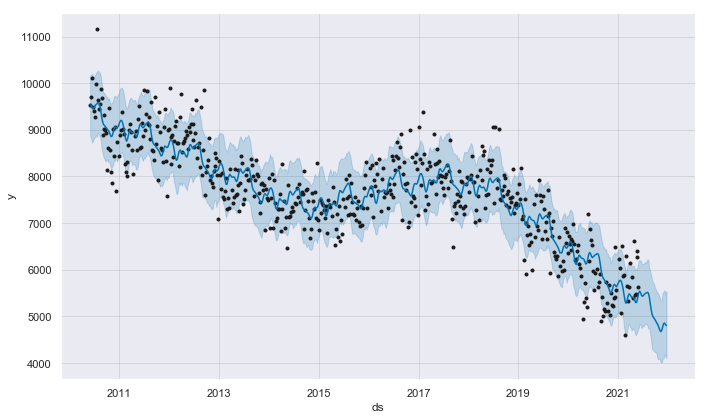

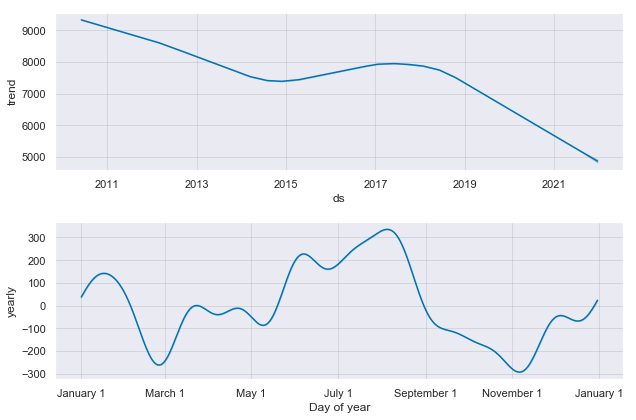

In [116]:
plot_fut_crude_oil_imp = m_crude_oil_imp.plot(for_crude_oil_imp)
plot_fut_crude_oil_imp = m_crude_oil_imp.plot_components(for_crude_oil_imp)

## Distillate Stock Forecast

#### Plot 1 shows actual and Modeled Data
#### Plot 2 shows the background trend of the model
#### Plot 3 shows you the yearly trend it observes in the data
#### Trends suggests high yearly variance in Distiallte Stock

C:\Users\cmosher\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1377: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

C:\Users\cmosher\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_base.py:239: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.



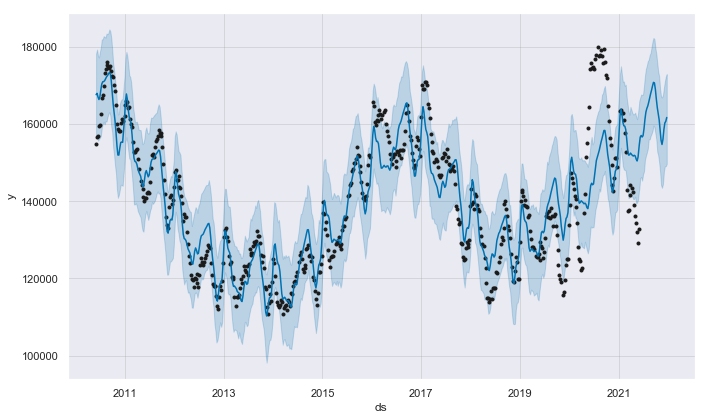

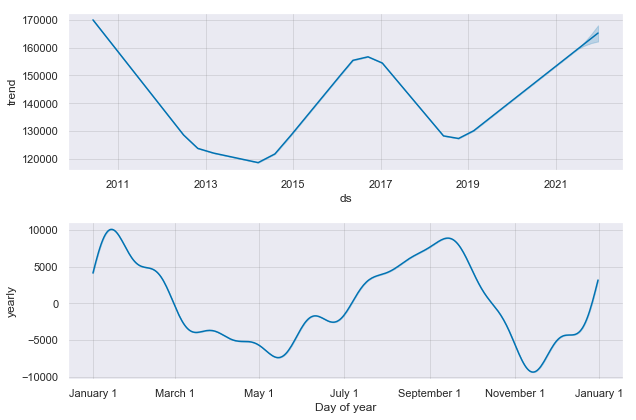

In [117]:
plot_fut_dist_stock = m_dist_stock.plot(for_dist_stock)
plot_fut_dist_stock = m_dist_stock.plot_components(for_dist_stock)

## USING FORECASTED FUNDAMENTAL DATA TO PREDICT RB1 and RB2

In [118]:
for_crude_stock = for_crude_stock[['ds','yhat']]
for_gasoline_stock = for_gasoline_stock[['ds','yhat']]
for_crude_oil_exp = for_crude_oil_exp[['ds','yhat']]
for_crude_oil_imp = for_crude_oil_imp[['ds','yhat']]
for_dist_stock = for_dist_stock[['ds','yhat']]

In [119]:
for_cs = for_crude_stock.rename(columns={'yhat':'Crude Stock'})
for_gs = for_gasoline_stock.rename(columns={'yhat':'Gas Stock'})
for_cexp = for_crude_oil_exp.rename(columns={'yhat':'Crude Exp'})
for_cimp = for_crude_oil_imp.rename(columns={'yhat':'Crude Imp'})
for_ds = for_dist_stock.rename(columns={'yhat':'Dist Stock'})

In [120]:
for_cs.head()

ds   Crude Stock
0 2010-06-04  1.094839e+06
1 2010-06-11  1.094479e+06
2 2010-06-18  1.091807e+06
3 2010-06-25  1.087031e+06
4 2010-07-02  1.081683e+06

In [121]:
for_data = pd.concat([for_cs,for_gs,for_cexp,for_cimp,for_ds],axis=1, join='inner')
for_data = for_data.loc[:, ~for_data.columns.duplicated()]
for_data.set_index('ds',inplace=True)


### FORECAST RB1 AND RB2 PRICES BASED ON MLR MODEL BUILT EARLIER

In [122]:
# Recall what order data was in for lr_model in X_Train
X_train.head()

Crude Oil Imp  Crude Oil Exp  Crude Stock  Gasoline Stock  \
Date                                                                    
2014-12-05         7668.0            374      1039276        216764.0   
2011-04-08         8571.0             34      1063705        209679.0   
2011-02-18         8106.0             33      1051629        238298.0   
2014-11-14         7638.0            411      1039724        204599.0   
2019-06-28         7585.0           2990      1113309        230642.0   

            Distillate Stock  
Date                          
2014-12-05            121751  
2011-04-08            150839  
2011-02-18            159937  
2014-11-14            114794  
2019-06-28            126788

In [123]:
for_data = for_data[['Crude Imp', 'Crude Exp', 'Crude Stock', 'Gas Stock','Dist Stock']]

In [124]:
for_data.head()

Crude Imp  Crude Exp   Crude Stock      Gas Stock     Dist Stock
ds                                                                            
2010-06-04  9539.809173 -31.991591  1.094839e+06  224111.409063  167568.903472
2010-06-11  9529.715031   1.864557  1.094479e+06  224438.319538  167890.489483
2010-06-18  9482.107446  49.650195  1.091807e+06  223978.852912  166963.470809
2010-06-25  9456.868734  76.827205  1.087031e+06  223284.940442  166299.090096
2010-07-02  9474.215560  57.271837  1.081683e+06  222811.420895  167039.916298

#### USE Multi Linear Regression model to predit RB1 and RB2 prices in the future six months

In [125]:
pred_rb1 = lr_model.predict(for_data)
pred_rb2 = lr_model2.predict(for_data)


In [126]:
pred_rb1

array([2.22054764, 2.2126932 , 2.22365326, 2.25024988, 2.28089203,
       2.30744579, 2.32916672, 2.34808466, 2.36457485, 2.37820754,
       2.39012101, 2.40193299, 2.41288611, 2.4204922 , 2.42472252,
       2.42963666, 2.43907948, 2.4517417 , 2.46300257, 2.47285324,
       2.48650729, 2.50920036, 2.53611313, 2.55377214, 2.55322576,
       2.54060057, 2.53160568, 2.53471525, 2.5418868 , 2.51704978,
       2.48941663, 2.46755089, 2.45271784, 2.43598846, 2.41289747,
       2.39270336, 2.39014229, 2.40878523, 2.43676364, 2.45910917,
       2.47194982, 2.48170993, 2.49191036, 2.49579366, 2.4852019 ,
       2.45170349, 2.46023485, 2.4852667 , 2.50668765, 2.50905895,
       2.49636152, 2.48684187, 2.49505657, 2.52045017, 2.55184102,
       2.58001925, 2.60310771, 2.62309106, 2.64072219, 2.65549549,
       2.66822642, 2.6806794 , 2.69262367, 2.70161318, 2.70689778,
       2.71197358, 2.72118709, 2.73426168, 2.74668586, 2.75658727,
       2.76896916, 2.79000373, 2.81523632, 2.83374267, 2.83467

#### Adding predicted data to DataFrame

In [127]:
# add predicted data to dataFrame
for_data['pred_RB1'] = \
(lr_model.coef_[0]*for_data['Crude Imp'])+\
(lr_model.coef_[1]*for_data['Crude Exp'])+\
(lr_model.coef_[2]*for_data['Crude Stock'])+\
(lr_model.coef_[3]*for_data['Gas Stock'])+\
(lr_model.coef_[4]*for_data['Dist Stock'])+\
lr_model.intercept_

for_data['pred_RB2'] = \
(lr_model2.coef_[0]*for_data['Crude Imp'])+\
(lr_model2.coef_[1]*for_data['Crude Exp'])+\
(lr_model2.coef_[2]*for_data['Crude Stock'])+\
(lr_model2.coef_[3]*for_data['Gas Stock'])+\
(lr_model2.coef_[4]*for_data['Dist Stock'])+\
lr_model2.intercept_

In [128]:
for_data.head()

Crude Imp  Crude Exp   Crude Stock      Gas Stock  \
ds                                                                
2010-06-04  9539.809173 -31.991591  1.094839e+06  224111.409063   
2010-06-11  9529.715031   1.864557  1.094479e+06  224438.319538   
2010-06-18  9482.107446  49.650195  1.091807e+06  223978.852912   
2010-06-25  9456.868734  76.827205  1.087031e+06  223284.940442   
2010-07-02  9474.215560  57.271837  1.081683e+06  222811.420895   

               Dist Stock  pred_RB1  pred_RB2  
ds                                             
2010-06-04  167568.903472  2.220548  2.203900  
2010-06-11  167890.489483  2.212693  2.196623  
2010-06-18  166963.470809  2.223653  2.205699  
2010-06-25  166299.090096  2.250250  2.230121  
2010-07-02  167039.916298  2.280892  2.260000

In [129]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=for_data.index, y=for_data['pred_RB1'], name='Pred RB1'))
fig.add_trace(go.Scatter(x=for_data.index, y=for_data['pred_RB2'], name='Pred RB2'))
fig.layout.update(title='<b>Predicted and Forecasted Values of RB1 & RB2 Based on Fundamental Data', xaxis={'title':'Date'},yaxis={'title':'Contract Price ($)'},hovermode='x', xaxis_rangeslider_visible=True)
pyo.iplot(fig)

In [130]:
## Difference Between RB1 vs RB2
for_data['1v2'] = for_data['pred_RB1']-for_data['pred_RB2']
for_data_future = for_data.loc['2021-06-01':]

In [131]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=for_data.index, y=for_data['1v2'], name='Pred 1v2'))
fig.add_trace(go.Scatter(x=for_data_future.index, y=for_data_future['1v2'], name='Forcasted 1v2'))
fig.layout.update(title='<b>Predicted and Forecasted difference between RB1 & RB2', xaxis={'title':'Date'},yaxis={'title':'Contract Price Difference ($)'},hovermode='x', xaxis_rangeslider_visible=True)
pyo.iplot(fig)

## TRADING RECOMMENDATION 
Ideally, my trading recomendation is based around the concept that when RB1 > RB2, we have Backwardation which is Bullish.  When RB1 < RB2, we have Contango with suggests a Bearish environment. 

Therefore, while RB1 > RB2, trade Bullish until a max value of RB1-RB2 is reached, which based on forecasts occurs on Nov 7, 2021

Trading the spread of RB1 vs RB2 remains Bullish to a peak diverage on Nov. 7, then becomes more Bearish

In [132]:
# MAX VALUE OF RB1 - RB2 occurs on Nov. 7, 2021
for_data_future[for_data_future['1v2']==for_data_future['1v2'].max()]

Crude Imp    Crude Exp   Crude Stock      Gas Stock  \
ds                                                                  
2021-11-07  4672.662977  3248.341048  1.146696e+06  227115.490423   

               Dist Stock  pred_RB1  pred_RB2       1v2  
ds                                                       
2021-11-07  155744.817637  1.131624   1.07661  0.055013

In [133]:
# MIN VALUES OF RB1 - RB2 occurs on Dec. 19, 2021
for_data_future[for_data_future['1v2']==for_data_future['1v2'].min()]

Crude Imp    Crude Exp   Crude Stock      Gas Stock  \
ds                                                                  
2021-12-19  4802.819002  3381.398164  1.137655e+06  241390.026325   

               Dist Stock  pred_RB1  pred_RB2       1v2  
ds                                                       
2021-12-19  161655.186348  1.063606  1.061871  0.001735

# 4) Risk/Reward

## Fundamental Problems with the Data
Due to data limitations of the free price curves available in Quandl, I chose to produce my trade analysis using a contiuous RB1 time series that doesn't account for expiry gaps (wich is evident in the 1v2 plots).  Unfortunately, the curve has limited real world applications without accounting for a roll methodology.  With additional time, I would want to explore my analysis using an adjusted perpetual futures curve using the Panama method or other.  Otherwise, I belive my construct is a sound approach that can be improved on with better data. 

I came across the below code whose function applies a Panama correction to a RB1 dataset, however did not have the time or futures domain expertise to properly test the code deploying it.  But going forward, this would be the approach I would take on the next steps of this Challenge.  

In [134]:
def get_pan_fut(market_data, expiry_dates, 
                data_cols=['Settle']):
    '''
    Converts a df of pairs of Futures contracts ('Front' & 'Back') into a continuous
    time series returned as df ("Panama Method"). Historical contracts are adjusted.
    :param market_data: hierachical df as returned by Quandl
    :param expiry_dates: DatetimeIndex
    :param data_cols: str
    :return: df
    '''
    #Prepare Input Data
    market_data.columns = ['Front', 'Back']
    expiry_dates = rb_expiry_dates
    
    #Initialize DFs for Futures data & roll adjustment for expired contracts
    pan_fut = pd.DataFrame(np.zeros((len(market_data.index), len(data_cols))), 
                    index = market_data.index, columns=data_cols)
    roll_adjustment_total = np.zeros([len(data_cols), 1])
    
    #Set data for last (unadjusted) Futures
    pan_fut['Settle'].iloc[pan_fut.index.get_loc(expiry_dates[-1]):] = market_data['Front'].iloc[
        market_data['Front'].index.get_loc(expiry_dates[-1]):]
    
    #Find roll gap backwards through contracts and cumsum for total adj
    for i in reversed(range(len(expiry_dates))):
        pan_fut['Settle'].loc[expiry_dates[i]] = roll_adjustment_total.reshape(
            1, len(data_cols)) + market_data['Back'].loc[expiry_dates[i]]
        roll_adjustment = market_data['Back'].iloc[
            market_data['Front'].index.get_loc(expiry_dates[i])
        ] - market_data['Front'].iloc[
            market_data['Back'].index.get_loc(expiry_dates[i])]
        roll_adjustment = np.repeat(roll_adjustment.mean(), len(data_cols))
        roll_adjustment = roll_adjustment.reshape(len(data_cols), 1)
        roll_adjustment_total += roll_adjustment
        #Most recent expired contract back to oldest + 1 contract
        if i > 0:
            roll_target = market_data['Front'].iloc[
                market_data['Front'].index.get_loc(expiry_dates[i - 1]) + 1:
                market_data['Front'].index.get_loc(expiry_dates[i])].index
            roll_adjustment_target = np.tile(roll_adjustment_total, len(roll_target)).T
            pan_fut['Settle'].loc[roll_target] = roll_adjustment_target[0] + market_data['Front'].loc[
                roll_target]
        #Oldest contract in data set
        else:
            roll_target = market_data['Front'].iloc[
                0:market_data['Front'].index.get_loc(expiry_dates[i])].index
            roll_adjustment_target = np.tile(roll_adjustment_total, len(roll_target)).T
            pan_fut['Settle'].loc[roll_target] = roll_adjustment_target[0] + market_data['Front'].loc[
                roll_target]
    return pan_fut

## ALTERNATIVE DATA 

## A look at factors that may be affecting supply and demand of gasoline
A lot of factors affect supply/demand of gasoline all over the world such as travel, geopolitics  Here is my attempt to look at some of those factors that may influence gasoline price and lead to an overview of Bullish or Bearish sentiment.  None of this data has been incorporated into my model and is only to a qualitative look at future patterns. 

The Beautiful Soup Python Lbrary is used to scrape webpage data

### A) Scrapping the TSA website for passenger throughfare:

In [135]:
URL1 = 'https://www.tsa.gov/coronavirus/passenger-throughput'
URL2 = 'https://www.goodcarbadcar.net/usa-auto-industry-total-sales-figures'

req = requests.get(URL1)

soup = BeautifulSoup(req.content,'html.parser')
table = soup.find_all('table')[0]

tsa_df = pd.read_html(str(table),flavor='html5lib' )[0]
tsa_df.set_index('Date',inplace=True)

In [136]:
tsa_df

2021 Traveler Throughput  2020 Traveler Throughput  \
Date                                                            
6/13/2021                 2097433.0                    544046   
6/12/2021                 1812797.0                    437119   
6/11/2021                 2028961.0                    519304   
6/10/2021                 1975189.0                    502209   
6/9/2021                  1669537.0                    386969   
...                             ...                       ...   
6/18/2020                       NaN                    576514   
6/17/2020                       NaN                    441829   
6/16/2020                       NaN                    417924   
6/15/2020                       NaN                    534528   
6/14/2020                       NaN                    544046   

           2019 Traveler Throughput  
Date                                 
6/13/2021                   2642083  
6/12/2021                   2318946  
6/11/2021                   2727860  
6/10/2021                   2675686  
6/9/2021                    2509058  
...                             ...  
6/18/2020                   2728786  
6/17/2020                   2552395  
6/16/2020                   2466574  
6/15/2020                   2699580  
6/14/2020                   2642083  

[365 rows x 3 columns]

In [137]:
tsa_df2021=tsa_df.loc[:'1/1/2021']

In [138]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=tsa_df2021.index, y=tsa_df2021['2021 Traveler Throughput'], name='2021 Travelers'))
fig.add_trace(go.Scatter(x=tsa_df2021.index, y=tsa_df2021['2020 Traveler Throughput'], name='2020 Travelers'))
fig.add_trace(go.Scatter(x=tsa_df2021.index, y=tsa_df2021['2019 Traveler Throughput'], name='2019 Travelers'))
fig['layout']['xaxis']['autorange'] = "reversed"

fig.layout.update(title='TSA Throughput comparing Traveler Traffic from 2019, 2020 & 2021', xaxis={'title':'Date'},yaxis={'title':'Travlers'},hovermode='x', xaxis_rangeslider_visible=True)
pyo.iplot(fig)

#### Passenger Througput substantially larger in 2021 than 2020 and rapidly approacing similar values at 2019

### B) Scrapping Auto Industry Sales Figures

In [139]:
URL2 = 'https://www.goodcarbadcar.net/usa-auto-industry-total-sales-figures'
autodata=[]
autodata = pd.DataFrame()

req = requests.get(URL2)

soup = BeautifulSoup(req.content,'html.parser')
table = soup.find_all('table')[0]

trs = table.find_all('tr')

for tr in trs:
    tds = tr.find_all('td')
    row = [td.text.replace('\n','') for td in tds]
    autodata = autodata.append(pd.Series(row),ignore_index=True)

autodata.columns = ['Year', 'Sales', 'Growth Rate YoY']
autodata = autodata.iloc[1:]

C:\Users\cmosher\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



In [140]:
autodata.head()

Year       Sales Growth Rate YoY
1  2005  16,881,867            0.00
2  2006  16,430,689           -2.75
3  2007  16,008,175           -2.64
4  2008  13,113,899          -22.07
5  2009  10,347,715          -26.73

In [141]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=autodata['Year'], y=autodata['Growth Rate YoY'], name='Auto Sales Growth'))

fig.layout.update(title='Year over Year Auto Sales Growth in USA', xaxis={'title':'Year'},yaxis={'title':'Growth Rate YoY'},hovermode='x', xaxis_rangeslider_visible=True)
pyo.iplot(fig)



#### As shown by both TSA throughfare traffic and the increase in auto sales from 2020-2021, the demand Gasoline will increase and is Bullish moving forward.  Additional data using Google Mobility can be examined which shows park visits, credit card swipes, etc.  https://www.google.com/covid19/mobility/

## 5) FIVE SENTENCE RECOMMENDATION

Based on the high correlation between key fundamental features affecting the prices of RB1 & RB2, Bullish Sentiment exists until a max divergence of RB1 & RB2 contracts on Nov. 7, 2021. 
In addition, based on Alternative data showing an increase in TSA traffic and car sales the demand for gasoline will continue to increase as the economy recovers from Covid-19 pandemic.